In [75]:
def accuracy(forecasts,targets):
  forecasts = forecasts.numpy()
  targets = targets.numpy()
  temp = forecaststargets/np.abs(forecaststargets)

  temp[temp==-1]=0 # masking the -1 with 0 because the correct ones are only the value 1
  accuracy_of_sign  = np.sum(temp)/len(forecasts)

  matches = temp==1
  mismatches = temp==0
  diff_values_matches = np.abs(targets[matches] - forecasts[matches])
  diff_values_mismatches = np.abs(targets[mismatches] - forecasts[mismatches])
  avg_price_paid_mismatches = np.mean(np.abs(targets[mismatches])) # forecasts is the diff between the DA and ID which is what you pay if you don't forecast correctly the sign difference (mismatch)
  avg_price_recieved_matches = np.mean(np.abs(targets[matches])) # forecasts is the diff between the DA and ID which is what you get paid if you do forecast correctly the sign difference (match)
  std_price_paid_mismatches = np.std(np.abs(targets[mismatches]))
  std_price_recieved_matches = np.std(np.abs(targets[matches]))

  return accuracy_of_sign, np.mean(diff_values_matches), np.mean(diff_values_mismatches), avg_price_paid_mismatches,avg_price_recieved_matches, std_price_paid_mismatches, std_price_recieved_matches


def revenues(forecasts,targets):

  forecasts = forecasts.numpy()
  targets = targets.numpy()
  temp = forecaststargets/np.abs(forecaststargets)
  revenues  = np.sum(temp*targets)

  return revenues 



class PricePredictionDatasetSimple(Dataset):
    def __init__(self, data, target_column='DA'):
        self.data = data
        self.target_column = target_column
        self.X, self.Y = self.prepare_data()

    def prepare_data(self):
        df = self.data
        num_days = len(df) // 24

        # Prepare the target
        Y = np.zeros((num_days, 24))
        for d in range(num_days):
            Y[d, :] = df.loc[df.index[d * 24:(d + 1) * 24], self.target_column].to_numpy()

        # Prepare features
        X = np.zeros((num_days, len(df.columns) * 24))
        for d in range(7, num_days):
            for i, col in enumerate(df.columns):
                X[d, i*24:(i+1)*24] = df.loc[df.index[(d - 1)*24:d*24], col].to_numpy()

        X = X[7:, :]
        Y = Y[7:, :]

        return torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32)

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


class PricePredictionDataset(Dataset):
    def __init__(self, data, target_column='DA'):
        self.data = data
        self.target_column = target_column
        self.X, self.Y = self.prepare_data()

    def prepare_data(self):
        df = self.data
        # We are fixing the dataset to exactly 690 days as per the old code
        # Ensure df has at least 690 * 24 rows
        num_days = 690  # fixed
        assert len(df) >= num_days * 24, "Data does not have enough rows for 690 days."

        # Prepare Y (Targets)
        Y = np.zeros((num_days, 24))
        for d in range(num_days):
            Y[d, :] = df.loc[df.index[d * 24:(d + 1) * 24], self.target_column].to_numpy()
        Y = Y[7:-1 :]  # skip first 7 days

        # Prepare X (Features)
        # The original code used a fixed shape and indexing
        # X of shape (700+1, 726) was mentioned, which allows indexing up to day=690 + 1
        # We'll replicate the code as is.
        X = np.zeros((700 + 1, 726))
        for d in range(7, 690 + 1):
            # DA prices history
            X[d, :24] = df.loc[df.index[(d - 1) * 24:d * 24], 'DA'].to_numpy()
            X[d, 24:48] = df.loc[df.index[(d - 2) * 24:(d - 1) * 24], 'DA'].to_numpy()
            X[d, 48:72] = df.loc[df.index[(d - 3) * 24:(d - 2) * 24], 'DA'].to_numpy()

            # ID prices history
            X[d, 72:96] = df.loc[df.index[(d - 7) * 24:(d - 6) * 24], 'ID'].to_numpy()
            X[d, 96:120] = df.loc[df.index[(d - 1) * 24:d * 24], 'ID'].to_numpy()
            X[d, 120:144] = df.loc[df.index[(d - 2) * 24:(d - 1) * 24], 'ID'].to_numpy()
            X[d, 144:168] = df.loc[df.index[(d - 3) * 24:(d - 2) * 24], 'ID'].to_numpy()
            X[d, 168:192] = df.loc[df.index[(d - 7) * 24:(d - 6) * 24], 'ID'].to_numpy()

            # Demand
            X[d, 192:216] = df.loc[df.index[d * 24:(d + 1) * 24], 'Demand'].to_numpy()
            X[d, 216:240] = df.loc[df.index[(d - 1) * 24:d * 24], 'Demand'].to_numpy()
            X[d, 240:264] = df.loc[df.index[(d - 7) * 24:(d - 6) * 24], 'Demand'].to_numpy()

            # Hour_Cos and Hour_Sin
            # Notice in original code, some indexes were skipped (like 264 to 288 isn't used)
            # We'll trust original code: Possibly some commented lines or placeholders were there.
            # Just replicate exact indexing as given previously.
            X[d, 288:312] = df.loc[df.index[d * 24:(d + 1) * 24], 'Hour_Cos'].to_numpy()
            X[d, 336:360] = df.loc[df.index[d * 24:(d + 1) * 24], 'Hour_Sin'].to_numpy()

            # Day_Cos, Day_Sin, Month_Cos, Month_Sin
            X[d, 360] = df.loc[df.index[(d - 2) * 24:(d - 1) * 24:24], 'Day_Cos'].to_numpy()
            X[d, 361] = df.loc[df.index[(d - 2) * 24:(d - 1) * 24:24], 'Day_Sin'].to_numpy()
            X[d, 362] = df.loc[df.index[(d - 2) * 24:(d - 1) * 24:24], 'Month_Cos'].to_numpy()
            X[d, 363] = df.loc[df.index[(d - 2) * 24:(d - 1) * 24:24], 'Month_Sin'].to_numpy()

            # Weekday
            X[d, 364] = df.loc[df.index[d * 24:(d + 1) * 24:24], 'Weekday'].to_numpy()

            # Predicted Wind and Solar Features
            X[d, 365:389] = df.loc[df.index[d * 24:(d + 1) * 24], 'Madrid_wind_v_component_Predicted'].to_numpy()
            X[d, 389:413] = df.loc[df.index[d * 24:(d + 1) * 24], 'Madrid_wind_u_component_Predicted'].to_numpy()
            X[d, 413:437] = df.loc[df.index[d * 24:(d + 1) * 24], 'Barcelona_wind_v_component_Predicted'].to_numpy()
            X[d, 437:461] = df.loc[df.index[d * 24:(d + 1) * 24], 'Barcelona_wind_u_component_Predicted'].to_numpy()

            X[d, 461:485] = df.loc[df.index[d * 24:(d + 1) * 24], 'Madrid_solar_radiation'].to_numpy()
            X[d, 485:509] = df.loc[df.index[d * 24:(d + 1) * 24], 'Seville_solar_radiation'].to_numpy()

            X[d, 509:533] = df.loc[df.index[(d - 1) * 24:d * 24], 'Madrid_solar_radiation'].to_numpy()
            X[d, 533:557] = df.loc[df.index[(d - 1) * 24:d * 24], 'Seville_solar_radiation'].to_numpy()

            X[d, 557:581] = df.loc[df.index[(d - 1) * 24:d * 24], 'Castile-La Mancha (Wind)_wind_v_component'].to_numpy()
            X[d, 581:605] = df.loc[df.index[(d - 1) * 24:d * 24], 'Castile-La Mancha (Wind)_wind_u_component'].to_numpy()

            # RES_gen_predicted
            #X[d, 605:629] = df.loc[df.index[d * 24:(d + 1) * 24], 'RES_gen_predicted'].to_numpy()

            X[d, 629:653] = df.loc[df.index[(d - 1) * 24:d * 24], 'Wind_Generation'].to_numpy()
            X[d, 653:677] = df.loc[df.index[(d - 1) * 24:d * 24], 'PV_Generation'].to_numpy()
            X[d, 677:701] = df.loc[df.index[(d - 2) * 24:(d - 1) * 24], 'Wind_Generation'].to_numpy()
            X[d, 701:725] = df.loc[df.index[(d - 2) * 24:(d - 1) * 24], 'PV_Generation'].to_numpy()

        # As per original code
        Xf = X[-1:, :]
        X = X[7:-1, :]

        # Convert to torch tensors
        return torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32)

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import time
import os
from datetime import datetime
#import optuna
import logging
import sys
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn.functional as F
import json
import matplotlib.pyplot as plt

In [106]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

my_old_columns = [
    'Year', 'Month', 'Day', 'Hour', 'DA', 'ID', 'Demand', 'Wind_Generation',
    'PV_Generation', 'Predicted_Demand', 'Price_EUR_MWh', 'Volume_MWh',
    'Weekday', 'Castile-La Mancha (Wind)_wind_u_component',
    'Castile-La Mancha (Wind)_wind_v_component',
    'Escatrón-Chiprana-Samper (Solar)_solar_radiation',
    'Madrid_solar_radiation', 'Madrid_wind_u_component',
    'Madrid_wind_v_component', 'Seville_solar_radiation',
    'Seville_wind_u_component', 'Seville_wind_v_component',
    'Madrid_wind_v_component_Predicted', 'Madrid_wind_u_component_Predicted',
    'Valencia_temperature', 'Barcelona_wind_u_component_Predicted',
    'Barcelona_wind_v_component_Predicted', 'Hour_Sin', 'Hour_Cos',
    'Day_Sin', 'Day_Cos', 'Month_Sin', 'Month_Cos', 'Diff'    
 ] #, 'RES_gen_predicted'

# Load the data
data_spain = pd.read_csv(r'../formatted_data/formatted_data_withWeatherPrediction.csv')
data_spain['Weekday'] = pd.to_datetime(data_spain[['Year', 'Month', 'Day']]).dt.weekday
data_spain['Diff'] = data_spain['DA'] - data_spain['ID']
# drop valid_time column
# Drop columns that you don't need if present
if 'valid_time' in data_spain.columns:
    data_spain = data_spain.drop(columns=['valid_time'])

# Now select only the old columns to ensure the same input set
data_spain = data_spain[my_old_columns]





# Define the PyTorch Model
class ProbNNModel(nn.Module):
    def __init__(self, input_size, output_size, distribution):
        super(ProbNNModel, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.distribution = distribution

        # Define layers
        self.batch_norm = nn.BatchNorm1d(input_size)
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)

        if distribution == 'Normal':
            self.fc4 = nn.Linear(128, output_size * 2)  # loc and scale
        else:
            raise NotImplementedError(f"Distribution {distribution} not implemented.")

    def forward(self, x):
        x = self.batch_norm(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)

        loc = x[:, :self.output_size]
        scale = 3e-3 + 3 * F.softplus(x[:, self.output_size:])
        return loc, scale

# Negative Log Likelihood loss for Normal distribution
class NegativeLogLikelihood(nn.Module):
    def __init__(self):
        super(NegativeLogLikelihood, self).__init__()

    def forward(self, loc, scale, target):
        two_pi = torch.tensor(2.0 * np.pi, device=loc.device, dtype=loc.dtype)
        log_prob = -0.5 * (torch.log(two_pi) + torch.log(scale**2) + ((target - loc)**2) / (scale**2))
        return -torch.mean(log_prob)


def train_model(model, train_loader, val_loader, params):
    criterion = NegativeLogLikelihood()
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])

    epochs = params.get('epochs', 1000)
    best_val_loss = float('inf')
    best_model_weights = None

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            loc, scale = model(inputs)
            loss = criterion(loc, scale, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation phase
        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for inputs, targets in val_loader:
                loc, scale = model(inputs)
                loss = criterion(loc, scale, targets)
                val_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        # Print progress every 50 epochs (you can adjust this)
        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss:.4f}, "
                  f"Val Loss: {avg_val_loss:.4f}")

        # Check if this is the best validation loss so far
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_weights = model.state_dict()

    # After training is complete, load the best model weights
    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)

    return model



# Define a function to train and evaluate a model for a given target column
def run_experiment(data, target_column, data_split=0.9, epochs=500):
    dataset = PricePredictionDataset(data, target_column=target_column)
    train_size = int(data_split * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    input_size = dataset.X.shape[1]
    output_size = 24
    model = ProbNNModel(input_size=input_size, output_size=output_size, distribution='Normal')

    params = {
        'learning_rate': 0.0001,
        'epochs': epochs  # you can change this as needed
    }

    # Train the model
    model = train_model(model, train_loader, val_loader, params)

    # Evaluate the model
    model.eval()
    forecasts, targets, scales = [], [], []
    with torch.no_grad():
        for inputs, target in val_loader:
            loc, scale = model(inputs)
            forecasts.append(loc)
            targets.append(target)
            scales.append(scale)

    # Flatten tensors
    forecasts_flat = torch.cat(forecasts, axis=0).flatten()
    targets_flat = torch.cat(targets, axis=0).flatten()
    scales_flat = torch.cat(scales, axis=0).flatten()

    # Plot predictions and confidence intervals
    plt.figure(figsize=(10,4))
    plt.title(f"{target_column} Forecast vs Target")
    plt.plot(targets_flat[-200:], label='Targets', color='k')
    plt.plot(forecasts_flat[-200:], label='Forecasts', color='b')
    plt.fill_between(range(200), 
                     forecasts_flat[-200:] - 1.96 * scales_flat[-200:], 
                     forecasts_flat[-200:] + 1.96 * scales_flat[-200:], 
                     color='b', alpha=0.2, label='95% CI')
    plt.legend()
    plt.show()

    # Compute RMSE
    mse_loss = nn.MSELoss()
    mse = mse_loss(forecasts_flat, targets_flat)
    rmse = torch.sqrt(mse)
    print(f"{target_column} RMSE: {rmse.item():.4f}")
    return forecasts_flat, targets_flat, scales_flat



# Here you can call your accuracy and revenue functions on the forecasts and targets, 
# especially for the Diff dataset where it makes the most sense.

# Example (assuming accuracy and revenues are defined):
# acc, mean_matches, mean_mismatches, avg_paid_mismatches, avg_received_matches, std_paid_mismatches, std_received_matches = accuracy(forecasts_diff.numpy(), targets_diff.numpy())
# total_revenues = revenues(forecasts_diff.numpy(), targets_diff.numpy())
# print("Accuracy of sign:", acc)
# print("Revenues:", total_revenues)


/tmp/ipykernel_420322/1216106862.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X[d, 360] = df.loc[df.index[(d - 2) * 24:(d - 1) * 24:24], 'Day_Cos'].to_numpy()
/tmp/ipykernel_420322/1216106862.py:116: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X[d, 361] = df.loc[df.index[(d - 2) * 24:(d - 1) * 24:24], 'Day_Sin'].to_numpy()
/tmp/ipykernel_420322/1216106862.py:117: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X[d, 362] = df.loc[df.index[(d - 2) * 24:(d - 

Epoch 50/500, Train Loss: 5.3903, Val Loss: 5.2072
Epoch 100/500, Train Loss: 5.2710, Val Loss: 4.9959
Epoch 150/500, Train Loss: 4.9350, Val Loss: 4.8793
Epoch 200/500, Train Loss: 4.6851, Val Loss: 4.7125
Epoch 250/500, Train Loss: 4.5468, Val Loss: 4.5062
Epoch 300/500, Train Loss: 4.3836, Val Loss: 4.3856
Epoch 350/500, Train Loss: 4.2256, Val Loss: 4.3662
Epoch 400/500, Train Loss: 4.1390, Val Loss: 4.4174
Epoch 450/500, Train Loss: 4.0528, Val Loss: 4.3608
Epoch 500/500, Train Loss: 4.3900, Val Loss: 4.5694


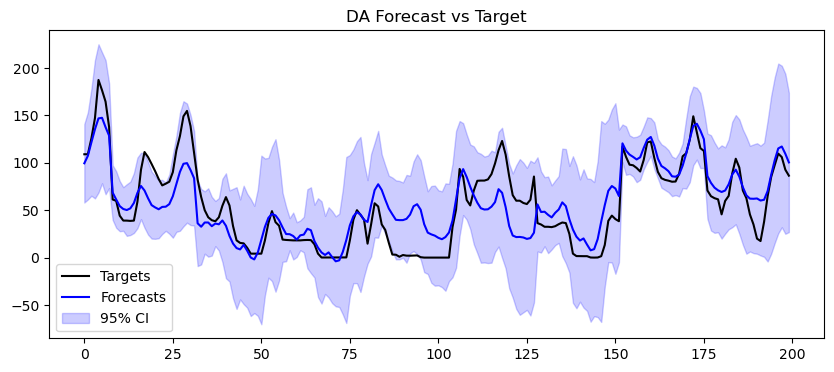

DA RMSE: 25.2324


In [56]:
# Run experiments for DA, ID, and Diff
forecasts_da, targets_da = run_experiment(data_spain, target_column='DA', data_split=0.9, epochs=500)



/tmp/ipykernel_420322/1216106862.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X[d, 360] = df.loc[df.index[(d - 2) * 24:(d - 1) * 24:24], 'Day_Cos'].to_numpy()
/tmp/ipykernel_420322/1216106862.py:116: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X[d, 361] = df.loc[df.index[(d - 2) * 24:(d - 1) * 24:24], 'Day_Sin'].to_numpy()
/tmp/ipykernel_420322/1216106862.py:117: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X[d, 362] = df.loc[df.index[(d - 2) * 24:(d - 

Epoch 50/1000, Train Loss: 5.3919, Val Loss: 5.4220
Epoch 100/1000, Train Loss: 5.0465, Val Loss: 5.0719
Epoch 150/1000, Train Loss: 4.8920, Val Loss: 4.8785
Epoch 200/1000, Train Loss: 4.7543, Val Loss: 4.7253
Epoch 250/1000, Train Loss: 4.6018, Val Loss: 4.5988
Epoch 300/1000, Train Loss: 4.4188, Val Loss: 4.4833
Epoch 350/1000, Train Loss: 4.4555, Val Loss: 4.4283
Epoch 400/1000, Train Loss: 4.2262, Val Loss: 4.4510
Epoch 450/1000, Train Loss: 4.1647, Val Loss: 4.3580
Epoch 500/1000, Train Loss: 4.0938, Val Loss: 4.5280
Epoch 550/1000, Train Loss: 4.0041, Val Loss: 4.6030
Epoch 600/1000, Train Loss: 4.0124, Val Loss: 4.4625
Epoch 650/1000, Train Loss: 3.8958, Val Loss: 4.8406
Epoch 700/1000, Train Loss: 3.8564, Val Loss: 4.7161
Epoch 750/1000, Train Loss: 3.8335, Val Loss: 4.7125
Epoch 800/1000, Train Loss: 3.7890, Val Loss: 4.9685
Epoch 850/1000, Train Loss: 3.7628, Val Loss: 5.1859
Epoch 900/1000, Train Loss: 3.8223, Val Loss: 4.8799
Epoch 950/1000, Train Loss: 3.7100, Val Loss: 5

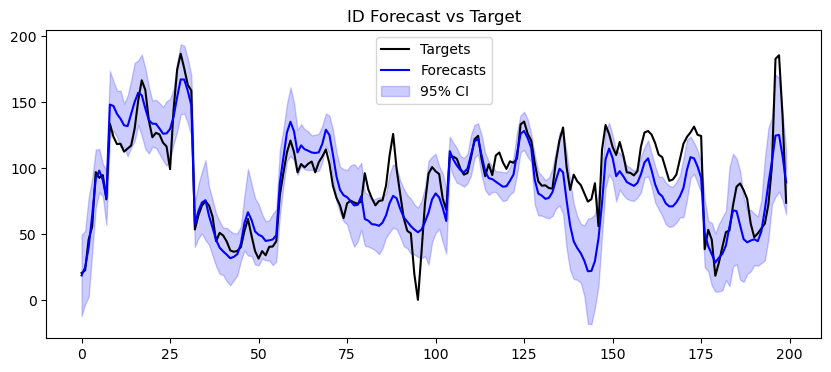

ID RMSE: 20.3922


In [57]:
forecasts_id, targets_id = run_experiment(data_spain, target_column='ID', data_split=0.9, epochs=1000)


In [114]:
forecasts_diff, targets_diff = run_experiment(data_spain, target_column='Diff', data_split=0.98, epochs=500)

/tmp/ipykernel_420322/964107889.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X[d, 360] = df.loc[df.index[(d - 2) * 24:(d - 1) * 24:24], 'Day_Cos'].to_numpy()
/tmp/ipykernel_420322/964107889.py:116: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X[d, 361] = df.loc[df.index[(d - 2) * 24:(d - 1) * 24:24], 'Day_Sin'].to_numpy()
/tmp/ipykernel_420322/964107889.py:117: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X[d, 362] = df.loc[df.index[(d - 2) * 24:(d - 1) 

KeyboardInterrupt: 

DA Model:
Sign Accuracy: nan
Mean Diff (Matches): 41.97031
Mean Diff (Mismatches): 37.385403
Avg Price Paid (Mismatches): 0.52966666
Avg Price Received (Matches): 71.695465
Std Price Paid (Mismatches): 0.7776652
Std Price Received (Matches): 44.817963
Total Revenues: 111398.85990544222

ID Model:
Sign Accuracy: 0.9227053140096618
Mean Diff (Matches): 38.389805
Mean Diff (Mismatches): 38.66233
Avg Price Paid (Mismatches): 5.0462494
Avg Price Received (Matches): 73.9197
Std Price Paid (Mismatches): 6.016125
Std Price Received (Matches): 42.38527
Total Revenues: 112303.38013220578

Diff Model:
Sign Accuracy: nan
Mean Diff (Matches): 7.465062
Mean Diff (Mismatches): 10.1196995
Avg Price Paid (Mismatches): 8.647763
Avg Price Received (Matches): 8.711134
Std Price Paid (Mismatches): 9.259958
Std Price Received (Matches): 8.603222
Total Revenues: 1918.5199841950089



/tmp/ipykernel_420322/2763507584.py:9: RuntimeWarning: invalid value encountered in divide
  temp = forecasts * targets / np.abs(forecasts * targets)
/tmp/ipykernel_420322/2763507584.py:98: RuntimeWarning: invalid value encountered in divide
  temp = forecasts_diff_np * targets_diff_np / np.abs(forecasts_diff_np * targets_diff_np)


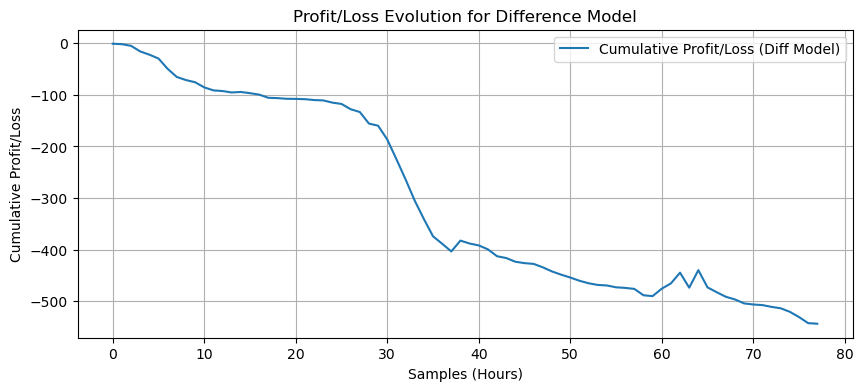

In [77]:
def accuracy(forecasts, targets):
    # Convert to numpy if they are not already
    if isinstance(forecasts, torch.Tensor):
        forecasts = forecasts.detach().cpu().numpy()
    if isinstance(targets, torch.Tensor):
        targets = targets.detach().cpu().numpy()

    # Compute sign correctness
    temp = forecasts * targets / np.abs(forecasts * targets)
    # Convert -1 to 0 for accuracy calculation
    temp[temp == -1] = 0

    accuracy_of_sign = np.sum(temp) / len(forecasts)

    matches = temp == 1
    mismatches = temp == 0

    diff_values_matches = np.abs(targets[matches] - forecasts[matches])
    diff_values_mismatches = np.abs(targets[mismatches] - forecasts[mismatches])

    avg_price_paid_mismatches = np.mean(np.abs(targets[mismatches]))
    avg_price_recieved_matches = np.mean(np.abs(targets[matches]))
    std_price_paid_mismatches = np.std(np.abs(targets[mismatches]))
    std_price_recieved_matches = np.std(np.abs(targets[matches]))

    return (accuracy_of_sign,
            np.mean(diff_values_matches),
            np.mean(diff_values_mismatches),
            avg_price_paid_mismatches,
            avg_price_recieved_matches,
            std_price_paid_mismatches,
            std_price_recieved_matches)

def revenues(forecasts, targets):
    if isinstance(forecasts, torch.Tensor):
        forecasts = forecasts.detach().cpu().numpy()
    if isinstance(targets, torch.Tensor):
        targets = targets.detach().cpu().numpy()

    # Check sign correctness
    sign_correct = (forecasts * targets) > 0
    # Gains and losses are always the absolute value of the target difference
    # Correct sign: +|targets|
    # Incorrect sign: -|targets|
    revenues = np.sum((2 * sign_correct - 1) * np.abs(targets))
    return revenues

# Evaluate DA model
acc_da, mean_diff_match_da, mean_diff_mismatch_da, avg_paid_mismatch_da, avg_received_match_da, std_paid_mismatch_da, std_received_match_da = accuracy(forecasts_da, targets_da)
revenues_da = revenues(forecasts_da, targets_da)

print("DA Model:")
print("Sign Accuracy:", acc_da)
print("Mean Diff (Matches):", mean_diff_match_da)
print("Mean Diff (Mismatches):", mean_diff_mismatch_da)
print("Avg Price Paid (Mismatches):", avg_paid_mismatch_da)
print("Avg Price Received (Matches):", avg_received_match_da)
print("Std Price Paid (Mismatches):", std_paid_mismatch_da)
print("Std Price Received (Matches):", std_received_match_da)
print("Total Revenues:", revenues_da)
print()

# Evaluate ID model
acc_id, mean_diff_match_id, mean_diff_mismatch_id, avg_paid_mismatch_id, avg_received_match_id, std_paid_mismatch_id, std_received_match_id = accuracy(forecasts_id, targets_id)
revenues_id = revenues(forecasts_id, targets_id)

print("ID Model:")
print("Sign Accuracy:", acc_id)
print("Mean Diff (Matches):", mean_diff_match_id)
print("Mean Diff (Mismatches):", mean_diff_mismatch_id)
print("Avg Price Paid (Mismatches):", avg_paid_mismatch_id)
print("Avg Price Received (Matches):", avg_received_match_id)
print("Std Price Paid (Mismatches):", std_paid_mismatch_id)
print("Std Price Received (Matches):", std_received_match_id)
print("Total Revenues:", revenues_id)
print()

# Evaluate Diff model
acc_diff, mean_diff_match_diff, mean_diff_mismatch_diff, avg_paid_mismatch_diff, avg_received_match_diff, std_paid_mismatch_diff, std_received_match_diff = accuracy(forecasts_diff, targets_diff)
revenues_diff = revenues(forecasts_diff, targets_diff)

print("Diff Model:")
print("Sign Accuracy:", acc_diff)
print("Mean Diff (Matches):", mean_diff_match_diff)
print("Mean Diff (Mismatches):", mean_diff_mismatch_diff)
print("Avg Price Paid (Mismatches):", avg_paid_mismatch_diff)
print("Avg Price Received (Matches):", avg_received_match_diff)
print("Std Price Paid (Mismatches):", std_paid_mismatch_diff)
print("Std Price Received (Matches):", std_received_match_diff)
print("Total Revenues:", revenues_diff)
print()

# Plot the profit or loss of the Difference model over time
forecasts_diff_np = forecasts_diff.detach().cpu().numpy() if isinstance(forecasts_diff, torch.Tensor) else forecasts_diff
targets_diff_np = targets_diff.detach().cpu().numpy() if isinstance(targets_diff, torch.Tensor) else targets_diff

# Compute sign array
temp = forecasts_diff_np * targets_diff_np / np.abs(forecasts_diff_np * targets_diff_np)
profit_loss_values = temp * targets_diff_np  # per-sample profit or loss

# Create a cumulative sum to see how the profit or loss evolves over the validation period
cumulative_profit_loss = np.cumsum(profit_loss_values)

plt.figure(figsize=(10,4))
plt.plot(cumulative_profit_loss, label='Cumulative Profit/Loss (Diff Model)')
plt.xlabel('Samples (Hours)')
plt.ylabel('Cumulative Profit/Loss')
plt.title('Profit/Loss Evolution for Difference Model')
plt.legend()
plt.grid(True)
plt.show()


/tmp/ipykernel_420322/964107889.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X[d, 360] = df.loc[df.index[(d - 2) * 24:(d - 1) * 24:24], 'Day_Cos'].to_numpy()
/tmp/ipykernel_420322/964107889.py:116: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X[d, 361] = df.loc[df.index[(d - 2) * 24:(d - 1) * 24:24], 'Day_Sin'].to_numpy()
/tmp/ipykernel_420322/964107889.py:117: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X[d, 362] = df.loc[df.index[(d - 2) * 24:(d - 1) 

Epoch 50/500, Train Loss: 5.3562, Val Loss: 5.3030
Epoch 100/500, Train Loss: 5.1110, Val Loss: 5.0666
Epoch 150/500, Train Loss: 4.9528, Val Loss: 4.9331
Epoch 200/500, Train Loss: 4.7668, Val Loss: 4.8494
Epoch 250/500, Train Loss: 4.4859, Val Loss: 4.5940
Epoch 300/500, Train Loss: 4.3108, Val Loss: 4.5485
Epoch 350/500, Train Loss: 4.4012, Val Loss: 4.6180
Epoch 400/500, Train Loss: 4.2813, Val Loss: 4.5497
Epoch 450/500, Train Loss: 4.1553, Val Loss: 4.5277
Epoch 500/500, Train Loss: 4.1260, Val Loss: 4.4631


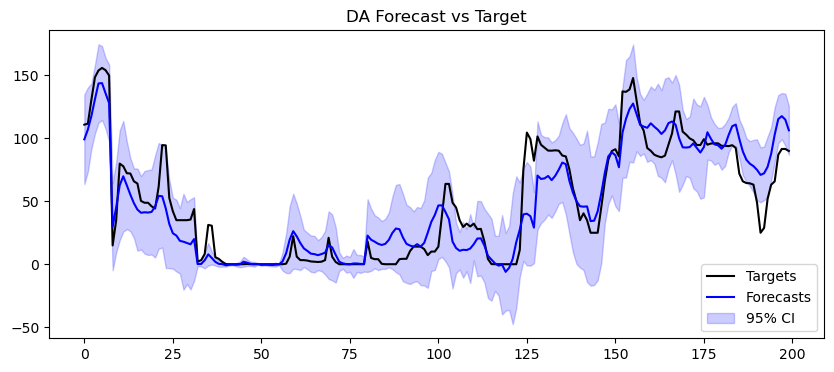

DA RMSE: 21.9213


In [117]:
forecasts_da, targets_da, scales_da = run_experiment(data_spain, target_column='DA', data_split=0.9, epochs=500) # not very nice


/tmp/ipykernel_420322/964107889.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X[d, 360] = df.loc[df.index[(d - 2) * 24:(d - 1) * 24:24], 'Day_Cos'].to_numpy()
/tmp/ipykernel_420322/964107889.py:116: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X[d, 361] = df.loc[df.index[(d - 2) * 24:(d - 1) * 24:24], 'Day_Sin'].to_numpy()
/tmp/ipykernel_420322/964107889.py:117: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X[d, 362] = df.loc[df.index[(d - 2) * 24:(d - 1) 

Epoch 50/600, Train Loss: 5.3675, Val Loss: 5.3278
Epoch 100/600, Train Loss: 5.0695, Val Loss: 5.0316
Epoch 150/600, Train Loss: 4.9019, Val Loss: 4.8537
Epoch 200/600, Train Loss: 4.7887, Val Loss: 4.7504
Epoch 250/600, Train Loss: 4.5677, Val Loss: 4.4651
Epoch 300/600, Train Loss: 4.4401, Val Loss: 4.3993
Epoch 350/600, Train Loss: 4.3687, Val Loss: 4.4036
Epoch 400/600, Train Loss: 4.3237, Val Loss: 4.3454
Epoch 450/600, Train Loss: 4.2357, Val Loss: 4.3398
Epoch 500/600, Train Loss: 4.1129, Val Loss: 4.2787
Epoch 550/600, Train Loss: 4.0238, Val Loss: 4.3125
Epoch 600/600, Train Loss: 4.0699, Val Loss: 4.2754


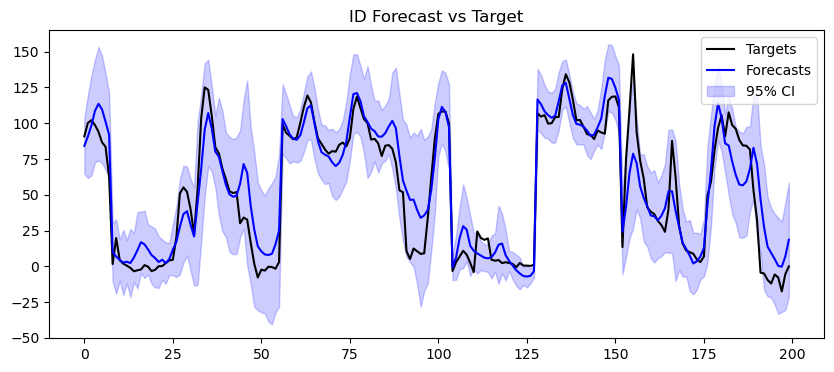

ID RMSE: 20.3508


In [116]:
forecasts_id, targets_id, scales_id = run_experiment(data_spain, target_column='ID', data_split=0.9, epochs=600) # This is nice 19 rmse

/tmp/ipykernel_420322/964107889.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X[d, 360] = df.loc[df.index[(d - 2) * 24:(d - 1) * 24:24], 'Day_Cos'].to_numpy()
/tmp/ipykernel_420322/964107889.py:116: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X[d, 361] = df.loc[df.index[(d - 2) * 24:(d - 1) * 24:24], 'Day_Sin'].to_numpy()
/tmp/ipykernel_420322/964107889.py:117: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X[d, 362] = df.loc[df.index[(d - 2) * 24:(d - 1) 

Epoch 50/700, Train Loss: 3.7895, Val Loss: 3.8485
Epoch 100/700, Train Loss: 3.7258, Val Loss: 3.8770
Epoch 150/700, Train Loss: 3.6094, Val Loss: 3.9926
Epoch 200/700, Train Loss: 3.5325, Val Loss: 4.1788
Epoch 250/700, Train Loss: 3.4019, Val Loss: 4.8556
Epoch 300/700, Train Loss: 3.3807, Val Loss: 4.6835
Epoch 350/700, Train Loss: 3.2771, Val Loss: 5.7864
Epoch 400/700, Train Loss: 3.2463, Val Loss: 6.7704
Epoch 450/700, Train Loss: 3.3128, Val Loss: 6.5195
Epoch 500/700, Train Loss: 3.1830, Val Loss: 6.7067
Epoch 550/700, Train Loss: 3.1479, Val Loss: 6.7705
Epoch 600/700, Train Loss: 3.2437, Val Loss: 7.0326
Epoch 650/700, Train Loss: 3.1446, Val Loss: 7.4772
Epoch 700/700, Train Loss: 3.0385, Val Loss: 7.7439


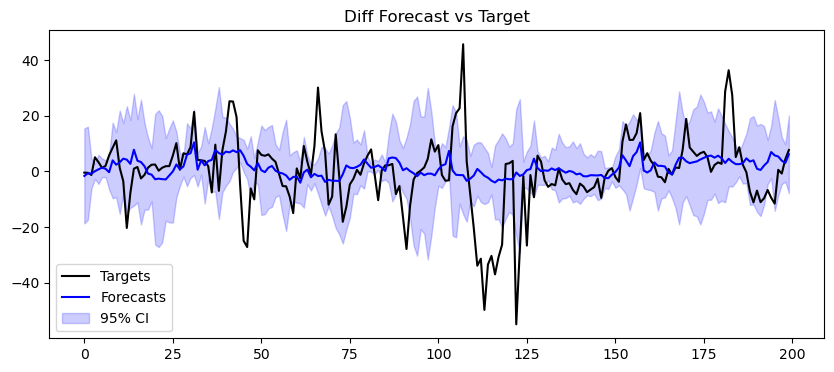

Diff RMSE: 11.7267


In [115]:
forecasts_diff, targets_diff, scales_diff = run_experiment(data_spain, target_column='Diff', data_split=0.9, epochs=700)

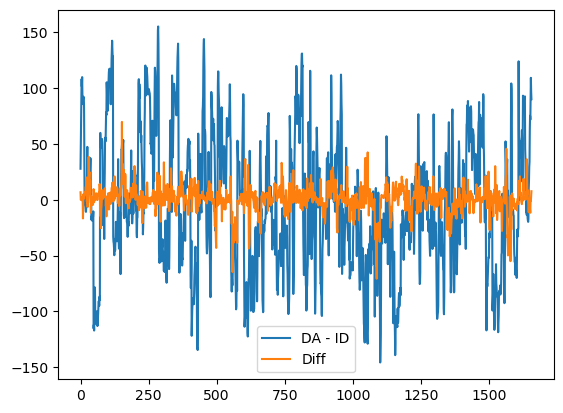

In [ ]:
# Lets compare the targets diff to check if the dataset is the same for the DA-ID and the Diff
targets_daid = targets_da - targets_id
plt.plot(targets_daid, label='DA - ID')
plt.plot(targets_diff, label='Diff')
plt.legend()
plt.show()




DA Model:
Sign Accuracy: nan
Mean Diff (Matches): 16.946934
Mean Diff (Mismatches): 3.0016992
Avg Price Paid (Mismatches): 0.16842106
Avg Price Received (Matches): 75.82294
Std Price Paid (Mismatches): 0.2520289
Std Price Received (Matches): 43.4969
Total Revenues: 120251.98001145199

ID Model:
Sign Accuracy: nan
Mean Diff (Matches): 15.303213
Mean Diff (Mismatches): 7.064734
Avg Price Paid (Mismatches): 2.6020756
Avg Price Received (Matches): 79.07205
Std Price Paid (Mismatches): 2.0403593
Std Price Received (Matches): 39.136883
Total Revenues: 126535.51018799096

Diff Model:
Sign Accuracy: 0.592391304347826
Mean Diff (Matches): 6.868764
Mean Diff (Mismatches): 10.744659
Avg Price Paid (Mismatches): 8.433333
Avg Price Received (Matches): 8.886096
Std Price Paid (Mismatches): 9.131252
Std Price Received (Matches): 9.142593
Total Revenues: 3024.759993378073

=== DA+ID (Separate) Model ===
Sign Accuracy: 0.5144927536231884
Mean Diff (Matches): 30.957289
Mean Diff (Mismatches): 45.948723


/tmp/ipykernel_420322/2763507584.py:9: RuntimeWarning: invalid value encountered in divide
  temp = forecasts * targets / np.abs(forecasts * targets)


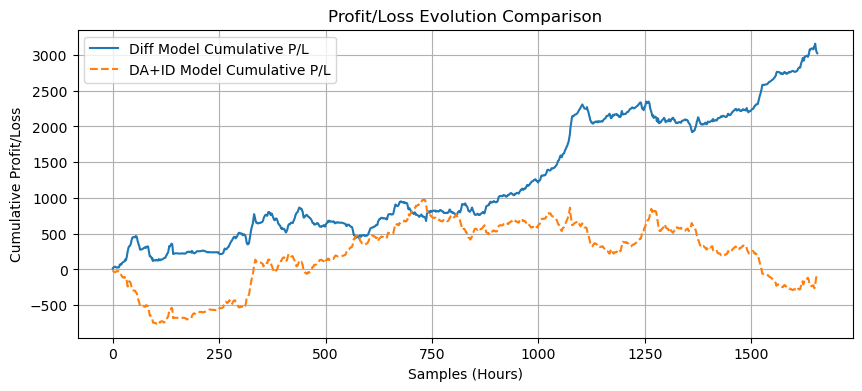

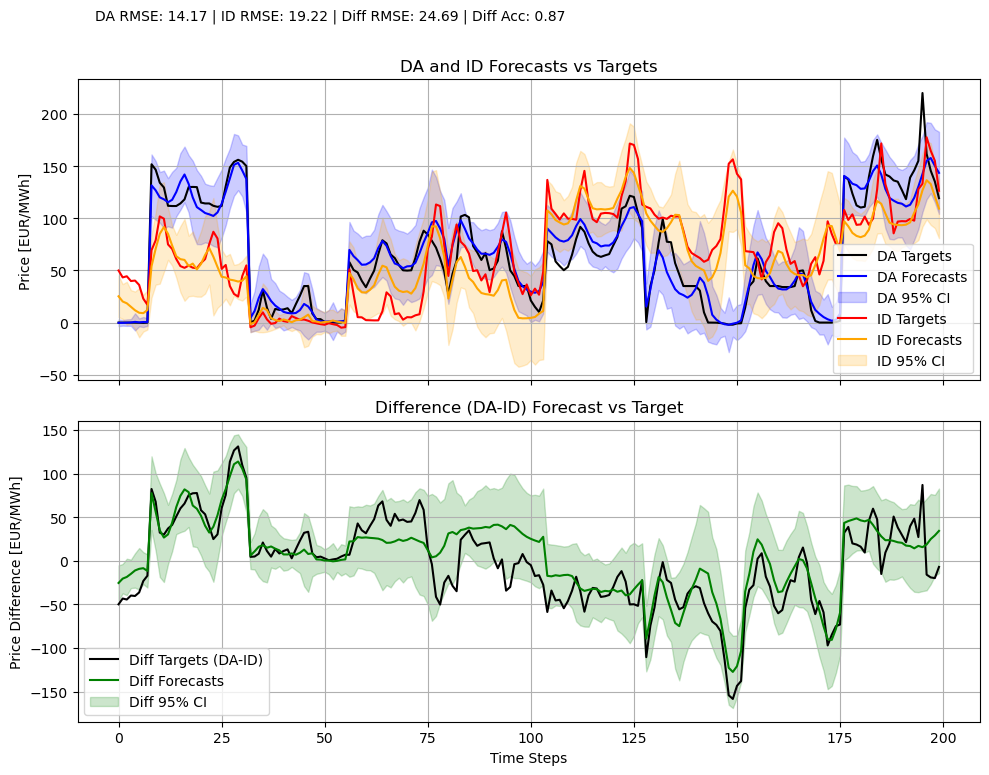

In [113]:
import matplotlib.pyplot as plt
import numpy as np
import torch



# Ensure these are torch tensors, if not already:
if not isinstance(forecasts_da, torch.Tensor):
    forecasts_da = torch.tensor(forecasts_da, dtype=torch.float32)
if not isinstance(targets_da, torch.Tensor):
    targets_da = torch.tensor(targets_da, dtype=torch.float32)

if not isinstance(forecasts_id, torch.Tensor):
    forecasts_id = torch.tensor(forecasts_id, dtype=torch.float32)
if not isinstance(targets_id, torch.Tensor):
    targets_id = torch.tensor(targets_id, dtype=torch.float32)

if not isinstance(forecasts_diff, torch.Tensor):
    forecasts_diff = torch.tensor(forecasts_diff, dtype=torch.float32)
if not isinstance(targets_diff, torch.Tensor):
    targets_diff = torch.tensor(targets_diff, dtype=torch.float32)

# Create predicted difference from separate DA and ID forecasts
predicted_diff_separate = forecasts_id - forecasts_da

# Evaluate DA model
acc_da, mean_diff_match_da, mean_diff_mismatch_da, avg_paid_mismatch_da, avg_received_match_da, std_paid_mismatch_da, std_received_match_da = accuracy(forecasts_da, targets_da)
revenues_da = revenues(forecasts_da, targets_da)

print("DA Model:")
print("Sign Accuracy:", acc_da)
print("Mean Diff (Matches):", mean_diff_match_da)
print("Mean Diff (Mismatches):", mean_diff_mismatch_da)
print("Avg Price Paid (Mismatches):", avg_paid_mismatch_da)
print("Avg Price Received (Matches):", avg_received_match_da)
print("Std Price Paid (Mismatches):", std_paid_mismatch_da)
print("Std Price Received (Matches):", std_received_match_da)
print("Total Revenues:", revenues_da)
print()

# Evaluate ID model
acc_id, mean_diff_match_id, mean_diff_mismatch_id, avg_paid_mismatch_id, avg_received_match_id, std_paid_mismatch_id, std_received_match_id = accuracy(forecasts_id, targets_id)
revenues_id = revenues(forecasts_id, targets_id)

print("ID Model:")
print("Sign Accuracy:", acc_id)
print("Mean Diff (Matches):", mean_diff_match_id)
print("Mean Diff (Mismatches):", mean_diff_mismatch_id)
print("Avg Price Paid (Mismatches):", avg_paid_mismatch_id)
print("Avg Price Received (Matches):", avg_received_match_id)
print("Std Price Paid (Mismatches):", std_paid_mismatch_id)
print("Std Price Received (Matches):", std_received_match_id)
print("Total Revenues:", revenues_id)
print()

# Evaluate Diff model
acc_diff, mean_diff_match_diff, mean_diff_mismatch_diff, avg_paid_mismatch_diff, avg_received_match_diff, std_paid_mismatch_diff, std_received_match_diff = accuracy(forecasts_diff, targets_diff)
revenues_diff = revenues(forecasts_diff, targets_diff)

print("Diff Model:")
print("Sign Accuracy:", acc_diff)
print("Mean Diff (Matches):", mean_diff_match_diff)
print("Mean Diff (Mismatches):", mean_diff_mismatch_diff)
print("Avg Price Paid (Mismatches):", avg_paid_mismatch_diff)
print("Avg Price Received (Matches):", avg_received_match_diff)
print("Std Price Paid (Mismatches):", std_paid_mismatch_diff)
print("Std Price Received (Matches):", std_received_match_diff)
print("Total Revenues:", revenues_diff)
print()

# Evaluate Separate DA+ID (Difference) model
acc_sep, mean_match_sep, mean_mismatch_sep, avg_paid_mismatch_sep, avg_rec_match_sep, std_paid_mismatch_sep, std_rec_match_sep = accuracy(predicted_diff_separate, targets_diff)
revenues_sep = revenues(predicted_diff_separate, targets_diff)

print("=== DA+ID (Separate) Model ===")
print("Sign Accuracy:", acc_sep)
print("Mean Diff (Matches):", mean_match_sep)
print("Mean Diff (Mismatches):", mean_mismatch_sep)
print("Avg Price Paid (Mismatches):", avg_paid_mismatch_sep)
print("Avg Price Received (Matches):", avg_rec_match_sep)
print("Std Price Paid (Mismatches):", std_paid_mismatch_sep)
print("Std Price Received (Matches):", std_rec_match_sep)
print("Total Revenues:", revenues_sep)
print()

# Plot cumulative profit/loss for both approaches for a visual comparison
# Convert to numpy if necessary
def to_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return x

predicted_diff_separate_np = to_numpy(predicted_diff_separate)
targets_diff_np = to_numpy(targets_diff)
forecasts_diff_np = to_numpy(forecasts_diff)

# Calculate profit/loss series
def profit_loss_series(pred_diff, actual_diff):
    sign_correct = (pred_diff * actual_diff) > 0
    profit_loss_values = (2 * sign_correct - 1) * np.abs(actual_diff)
    cumulative_profit_loss = np.cumsum(profit_loss_values)
    return cumulative_profit_loss

cumulative_profit_loss_diff = profit_loss_series(forecasts_diff_np, targets_diff_np)
cumulative_profit_loss_sep = profit_loss_series(predicted_diff_separate_np, targets_diff_np)

plt.figure(figsize=(10,4))
plt.plot(cumulative_profit_loss_diff, label='Diff Model Cumulative P/L')
plt.plot(cumulative_profit_loss_sep, label='DA+ID Model Cumulative P/L', linestyle='--')
plt.xlabel('Samples (Hours)')
plt.ylabel('Cumulative Profit/Loss')
plt.title('Profit/Loss Evolution Comparison')
plt.legend()
plt.grid(True)
plt.show()

# Now the code at the end for plotting the combined graph:
plot_length = 200

forecasts_da_np = to_numpy(forecasts_da)[-plot_length:]
targets_da_np = to_numpy(targets_da)[-plot_length:]
scales_da_np = to_numpy(scales_da)[-plot_length:]

forecasts_id_np = to_numpy(forecasts_id)[-plot_length:]
targets_id_np = to_numpy(targets_id)[-plot_length:]
scales_id_np = to_numpy(scales_id)[-plot_length:]

# Compute difference
diff_forecasts_np = forecasts_da_np- forecasts_id_np 
diff_targets_np = targets_da_np - targets_id_np 
diff_scales_np = np.sqrt(scales_da_np**2 + scales_id_np**2)

# Compute RMSE
mse_da = np.mean((forecasts_da_np - targets_da_np)**2)
rmse_da = np.sqrt(mse_da)

mse_id = np.mean((forecasts_id_np - targets_id_np)**2)
rmse_id = np.sqrt(mse_id)

mse_diff = np.mean((diff_forecasts_np - diff_targets_np)**2)
rmse_diff = np.sqrt(mse_diff)



def sign_accuracy(pred, actual):
    sign_correct = (pred * actual) > 0
    if len(sign_correct) > 0:
        return np.sum(sign_correct) / len(sign_correct)
    return np.nan


acc_diff_plot = sign_accuracy(diff_forecasts_np, diff_targets_np)

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

axes[0].plot(targets_da_np, label='DA Targets', color='black')
axes[0].plot(forecasts_da_np, label='DA Forecasts', color='blue')
axes[0].fill_between(np.arange(plot_length),
                     forecasts_da_np - 1.96 * scales_da_np,
                     forecasts_da_np + 1.96 * scales_da_np,
                     color='blue', alpha=0.2, label='DA 95% CI')

axes[0].plot(targets_id_np, label='ID Targets', color='red')
axes[0].plot(forecasts_id_np, label='ID Forecasts', color='orange')
axes[0].fill_between(np.arange(plot_length),
                     forecasts_id_np - 1.96 * scales_id_np,
                     forecasts_id_np + 1.96 * scales_id_np,
                     color='orange', alpha=0.2, label='ID 95% CI')

axes[0].set_title("DA and ID Forecasts vs Targets")
axes[0].set_ylabel("Price [EUR/MWh]")
axes[0].legend()
axes[0].grid(True)

axes[1].plot(diff_targets_np, label='Diff Targets (DA-ID)', color='black')
axes[1].plot(diff_forecasts_np, label='Diff Forecasts', color='green')
axes[1].fill_between(np.arange(plot_length),
                     diff_forecasts_np - 1.96 * diff_scales_np,
                     diff_forecasts_np + 1.96 * diff_scales_np,
                     color='green', alpha=0.2, label='Diff 95% CI')

axes[1].set_title("Difference (DA-ID) Forecast vs Target")
axes[1].set_xlabel("Time Steps")
axes[1].set_ylabel("Price Difference [EUR/MWh]")
axes[1].legend()
axes[1].grid(True)

fig.text(0.1, 0.95, f"DA RMSE: {rmse_da:.2f} | ID RMSE: {rmse_id:.2f} | Diff RMSE: {rmse_diff:.2f} | Diff Acc: {acc_diff_plot:.2f}", fontsize=10, transform=fig.transFigure)

plt.tight_layout(rect=[0,0,1,0.92])
plt.show()
fig.savefig("combined_plot.png", dpi=300)


/tmp/ipykernel_420322/2763507584.py:9: RuntimeWarning: invalid value encountered in divide
  temp = forecasts * targets / np.abs(forecasts * targets)


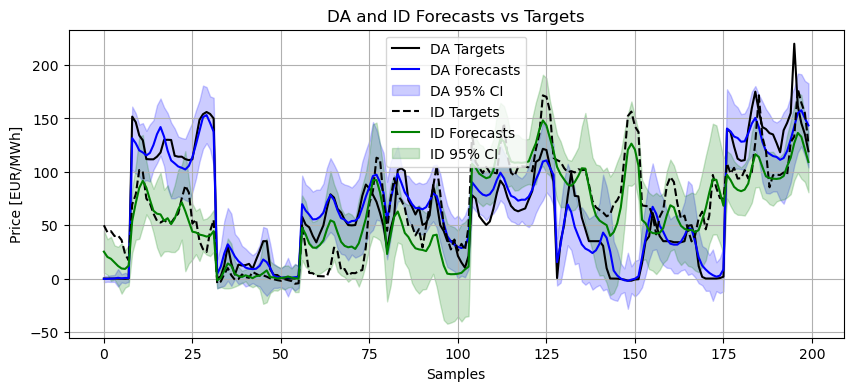

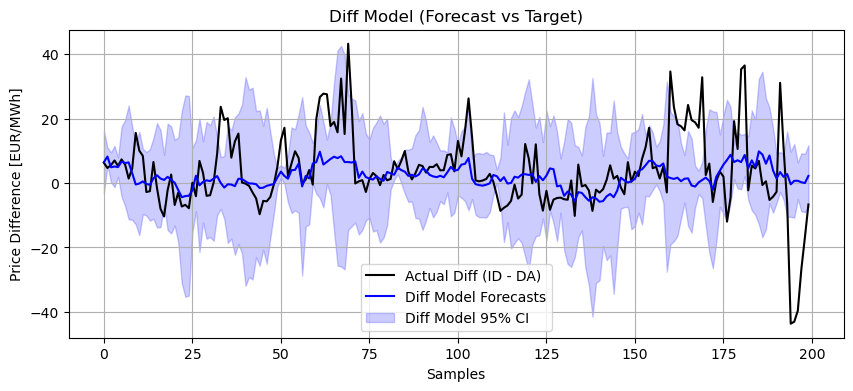

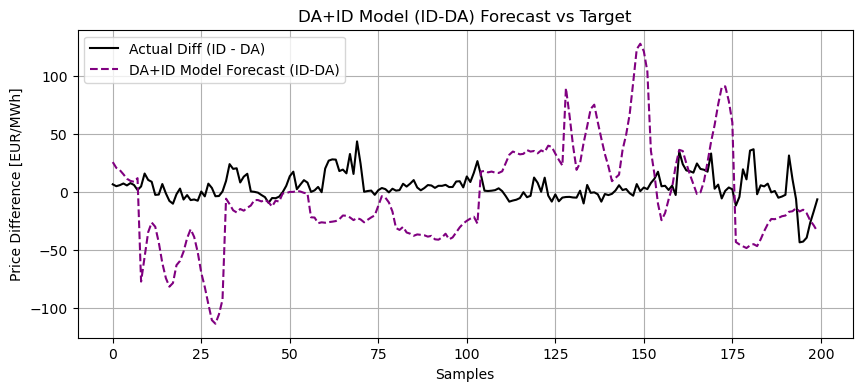

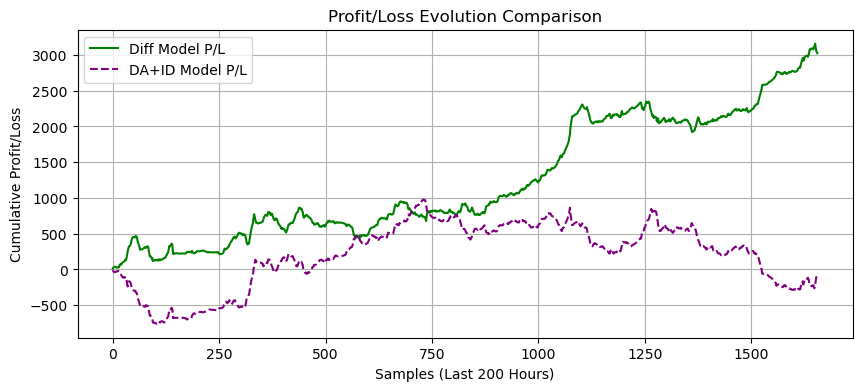

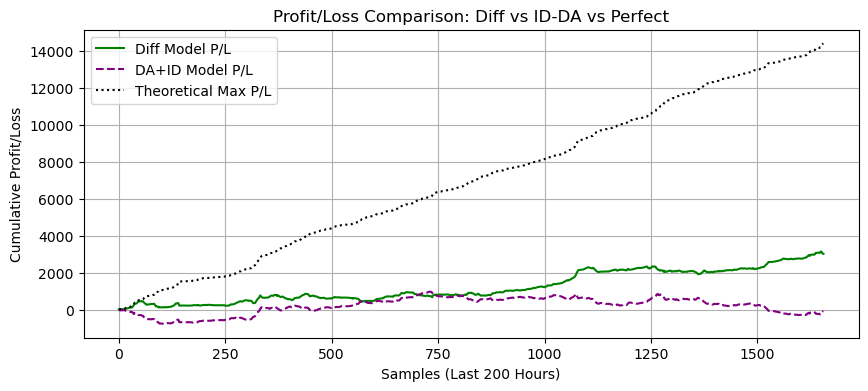

In [109]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Ensure these are torch tensors
if not isinstance(forecasts_da, torch.Tensor):
    forecasts_da = torch.tensor(forecasts_da, dtype=torch.float32)
if not isinstance(targets_da, torch.Tensor):
    targets_da = torch.tensor(targets_da, dtype=torch.float32)

if not isinstance(forecasts_id, torch.Tensor):
    forecasts_id = torch.tensor(forecasts_id, dtype=torch.float32)
if not isinstance(targets_id, torch.Tensor):
    targets_id = torch.tensor(targets_id, dtype=torch.float32)

if not isinstance(forecasts_diff, torch.Tensor):
    forecasts_diff = torch.tensor(forecasts_diff, dtype=torch.float32)
if not isinstance(targets_diff, torch.Tensor):
    targets_diff = torch.tensor(targets_diff, dtype=torch.float32)

predicted_diff_separate = forecasts_id - forecasts_da

# Evaluate models
acc_da, mean_diff_match_da, mean_diff_mismatch_da, avg_paid_mismatch_da, avg_received_match_da, std_paid_mismatch_da, std_received_match_da = accuracy(forecasts_da, targets_da)
revenues_da = revenues(forecasts_da, targets_da)

acc_id, mean_diff_match_id, mean_diff_mismatch_id, avg_paid_mismatch_id, avg_received_match_id, std_paid_mismatch_id, std_received_match_id = accuracy(forecasts_id, targets_id)
revenues_id = revenues(forecasts_id, targets_id)

acc_diff, mean_diff_match_diff, mean_diff_mismatch_diff, avg_paid_mismatch_diff, avg_received_match_diff, std_paid_mismatch_diff, std_received_match_diff = accuracy(forecasts_diff, targets_diff)
revenues_diff = revenues(forecasts_diff, targets_diff)

acc_sep, mean_match_sep, mean_mismatch_sep, avg_paid_mismatch_sep, avg_rec_match_sep, std_paid_mismatch_sep, std_rec_match_sep = accuracy(predicted_diff_separate, targets_diff)
revenues_sep = revenues(predicted_diff_separate, targets_diff)

# Convert tensors to numpy
def to_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return x

forecasts_da_np = to_numpy(forecasts_da)
targets_da_np = to_numpy(targets_da)
scales_da_np = to_numpy(scales_da)

forecasts_id_np = to_numpy(forecasts_id)
targets_id_np = to_numpy(targets_id)
scales_id_np = to_numpy(scales_id)

forecasts_diff_np = to_numpy(forecasts_diff)
targets_diff_np = to_numpy(targets_diff)
predicted_diff_separate_np = to_numpy(predicted_diff_separate)

# Profit/Loss series calculation
def profit_loss_series(pred_diff, actual_diff):
    sign_correct = (pred_diff * actual_diff) > 0
    profit_loss_values = (2 * sign_correct - 1) * np.abs(actual_diff)
    cumulative_profit_loss = np.cumsum(profit_loss_values)
    return cumulative_profit_loss

cumulative_profit_loss_diff = profit_loss_series(forecasts_diff_np, targets_diff_np)
cumulative_profit_loss_sep = profit_loss_series(predicted_diff_separate_np, targets_diff_np)

# Theoretical max profit: always correct sign
# This would be the cumulative sum of the absolute target differences:
cumulative_profit_loss_perfect = np.cumsum(np.abs(targets_diff_np))

# Subset last 200 points for plotting time series (as previously done)
plot_length = 200
forecasts_da_np_plt = forecasts_da_np[-plot_length:]
targets_da_np_plt = targets_da_np[-plot_length:]
scales_da_np_plt = scales_da_np[-plot_length:]

forecasts_id_np_plt = forecasts_id_np[-plot_length:]
targets_id_np_plt = targets_id_np[-plot_length:]
scales_id_np_plt = scales_id_np[-plot_length:]

forecasts_diff_np_plt = forecasts_diff_np[-plot_length:]
targets_diff_np_plt = targets_diff_np[-plot_length:]

predicted_diff_separate_np_plt = predicted_diff_separate_np[-plot_length:]

# Compute difference stats
diff_forecasts_np = forecasts_id_np_plt - forecasts_da_np_plt
diff_targets_np = targets_id_np_plt - targets_da_np_plt

# Compute combined std for difference using variance addition
diff_scales_np = np.sqrt(scales_da_np_plt**2 + scales_id_np_plt**2)

# === 1st Plot: DA and ID forecasts vs Targets (DA=blue, ID=green) ===
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(targets_da_np_plt, label='DA Targets', color='black')
ax.plot(forecasts_da_np_plt, label='DA Forecasts', color='blue')
ax.fill_between(np.arange(plot_length),
                forecasts_da_np_plt - 1.96 * scales_da_np_plt,
                forecasts_da_np_plt + 1.96 * scales_da_np_plt,
                color='blue', alpha=0.2, label='DA 95% CI')

ax.plot(targets_id_np_plt, label='ID Targets', color='black', linestyle='--')
ax.plot(forecasts_id_np_plt, label='ID Forecasts', color='green')
ax.fill_between(np.arange(plot_length),
                forecasts_id_np_plt - 1.96 * scales_id_np_plt,
                forecasts_id_np_plt + 1.96 * scales_id_np_plt,
                color='green', alpha=0.2, label='ID 95% CI')

ax.set_title("DA and ID Forecasts vs Targets")
ax.set_xlabel("Samples")
ax.set_ylabel("Price [EUR/MWh]")
ax.legend()
ax.grid(True)
plt.show()

# === 2nd Plot: Diff model forecasts vs targets_diff (blue line) ===
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(targets_diff_np_plt, label='Actual Diff (ID - DA)', color='black')
ax.plot(forecasts_diff_np_plt, label='Diff Model Forecasts', color='blue')
# If you have scales for diff model as well (scales_diff), include CI
# Assuming scales_diff is available as scales_diff_np:
if 'scales_diff_np' in locals():
    scales_diff_np_plt = scales_diff_np[-plot_length:]
    ax.fill_between(np.arange(plot_length),
                    forecasts_diff_np_plt - 1.96 * scales_diff_np_plt,
                    forecasts_diff_np_plt + 1.96 * scales_diff_np_plt,
                    color='blue', alpha=0.2, label='Diff Model 95% CI')

ax.set_title("Diff Model (Forecast vs Target)")
ax.set_xlabel("Samples")
ax.set_ylabel("Price Difference [EUR/MWh]")
ax.legend()
ax.grid(True)
plt.show()

# === 3rd Plot: Separate (ID-DA) model vs targets_diff (purple) ===
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(targets_diff_np_plt, label='Actual Diff (ID - DA)', color='black')
ax.plot(predicted_diff_separate_np_plt, label='DA+ID Model Forecast (ID-DA)', color='purple', linestyle='--')
ax.set_title("DA+ID Model (ID-DA) Forecast vs Target")
ax.set_xlabel("Samples")
ax.set_ylabel("Price Difference [EUR/MWh]")
ax.legend()
ax.grid(True)
plt.show()

# === 4th Plot: Profit Diff model vs ID-DA model ===
cumulative_profit_loss_diff_plt = cumulative_profit_loss_diff
cumulative_profit_loss_sep_plt = cumulative_profit_loss_sep

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(cumulative_profit_loss_diff_plt, label='Diff Model P/L', color='green')
ax.plot(cumulative_profit_loss_sep_plt, label='DA+ID Model P/L', color='purple', linestyle='--')
ax.set_title('Profit/Loss Evolution Comparison')
ax.set_xlabel('Samples (Last 200 Hours)')
ax.set_ylabel('Cumulative Profit/Loss')
ax.legend()
ax.grid(True)
plt.show()

# === 5th Plot: Profit Diff model vs ID-DA vs Theoretical Max ===
cumulative_profit_loss_perfect_plt = cumulative_profit_loss_perfect

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(cumulative_profit_loss_diff_plt, label='Diff Model P/L', color='green')
ax.plot(cumulative_profit_loss_sep_plt, label='DA+ID Model P/L', color='purple', linestyle='--')
ax.plot(cumulative_profit_loss_perfect_plt, label='Theoretical Max P/L', color='black', linestyle=':')
ax.set_title('Profit/Loss Comparison: Diff vs ID-DA vs Perfect')
ax.set_xlabel('Samples (Last 200 Hours)')
ax.set_ylabel('Cumulative Profit/Loss')
ax.legend()
ax.grid(True)
plt.show()


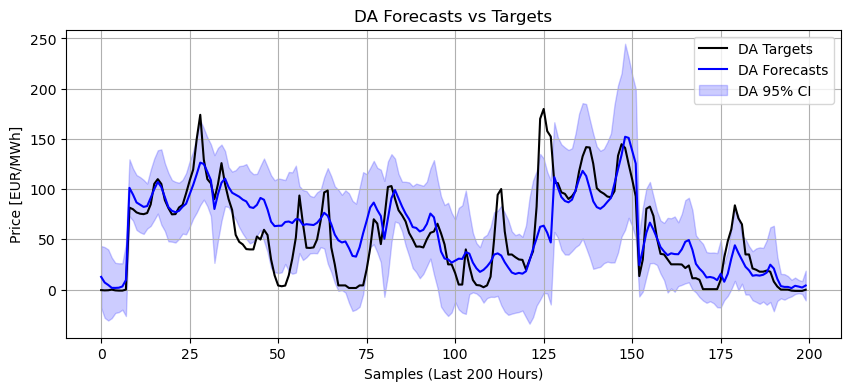

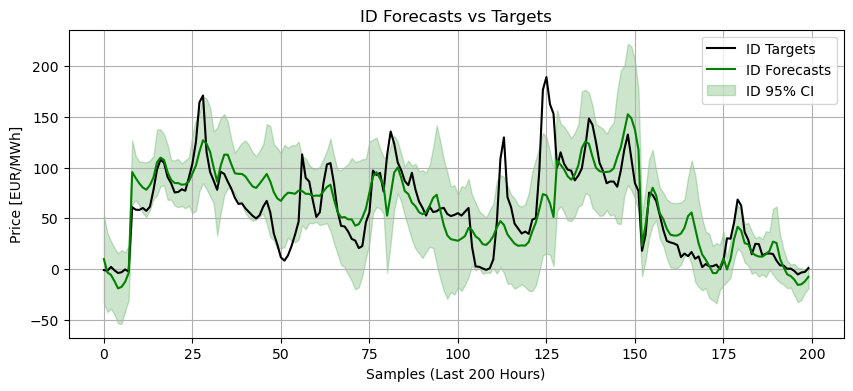

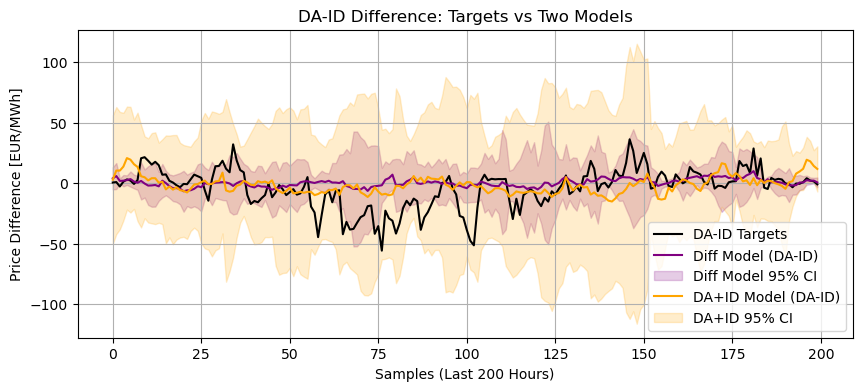

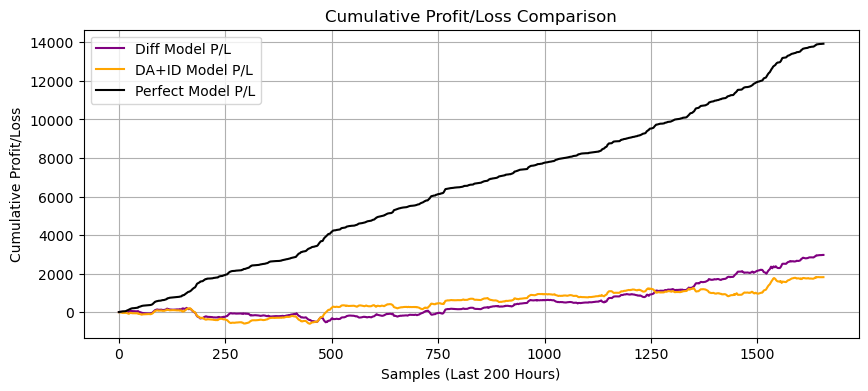

In [123]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def to_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return x

# Convert all relevant tensors to numpy
forecasts_da_np = to_numpy(forecasts_da)
targets_da_np = to_numpy(targets_da)
scales_da_np = to_numpy(scales_da)

forecasts_id_np = to_numpy(forecasts_id)
targets_id_np = to_numpy(targets_id)
scales_id_np = to_numpy(scales_id)

forecasts_diff_np = to_numpy(forecasts_diff)
targets_diff_np = to_numpy(targets_diff)
scales_diff_np = to_numpy(scales_diff) # Assuming this exists

predicted_diff_separate_np = forecasts_da_np - forecasts_id_np
diff_targets_np = targets_da_np - targets_id_np

# Define plot length
plot_length = 200
forecasts_da_np_plt = forecasts_da_np[-plot_length:]
targets_da_np_plt = targets_da_np[-plot_length:]
scales_da_np_plt = scales_da_np[-plot_length:]

forecasts_id_np_plt = forecasts_id_np[-plot_length:]
targets_id_np_plt = targets_id_np[-plot_length:]
scales_id_np_plt = scales_id_np[-plot_length:]

forecasts_diff_np_plt = forecasts_diff_np[-plot_length:]
targets_diff_np_plt = targets_diff_np[-plot_length:]
scales_diff_np_plt = scales_diff_np[-plot_length:]

predicted_diff_separate_np_plt = predicted_diff_separate_np[-plot_length:]
diff_targets_np_plt = diff_targets_np[-plot_length:]

# For the DA+ID difference model (separate), compute CI
diff_scales_separate_np = np.sqrt(scales_da_np_plt**2 + scales_id_np_plt**2)

def profit_loss_series(pred_diff, actual_diff):
    sign_correct = (pred_diff * actual_diff) > 0
    profit_loss_values = (2 * sign_correct - 1) * np.abs(actual_diff)
    return np.cumsum(profit_loss_values)

cumulative_profit_loss_diff = profit_loss_series(forecasts_diff_np, diff_targets_np)
cumulative_profit_loss_sep = profit_loss_series(predicted_diff_separate_np, diff_targets_np)
cumulative_profit_loss_perfect = np.cumsum(np.abs(diff_targets_np))

cumulative_profit_loss_diff_plt = cumulative_profit_loss_diff
cumulative_profit_loss_sep_plt = cumulative_profit_loss_sep
cumulative_profit_loss_perfect_plt = cumulative_profit_loss_perfect

### 1. Plot DA forecasts vs DA targets with CI ###
fig1, ax1 = plt.subplots(figsize=(10,4))
ax1.plot(targets_da_np_plt, label='DA Targets', color='black')
ax1.plot(forecasts_da_np_plt, label='DA Forecasts', color='blue')
ax1.fill_between(np.arange(plot_length),
                 forecasts_da_np_plt - 1.96 * scales_da_np_plt,
                 forecasts_da_np_plt + 1.96 * scales_da_np_plt,
                 color='blue', alpha=0.2, label='DA 95% CI')
ax1.set_title("DA Forecasts vs Targets")
ax1.set_xlabel("Samples (Last 200 Hours)")
ax1.set_ylabel("Price [EUR/MWh]")
ax1.legend()
ax1.grid(True)
plt.show()

### 2. Plot ID forecasts vs ID targets with CI ###
fig2, ax2 = plt.subplots(figsize=(10,4))
ax2.plot(targets_id_np_plt, label='ID Targets', color='black')
ax2.plot(forecasts_id_np_plt, label='ID Forecasts', color='green')
ax2.fill_between(np.arange(plot_length),
                 forecasts_id_np_plt - 1.96 * scales_id_np_plt,
                 forecasts_id_np_plt + 1.96 * scales_id_np_plt,
                 color='green', alpha=0.2, label='ID 95% CI')
ax2.set_title("ID Forecasts vs Targets")
ax2.set_xlabel("Samples (Last 200 Hours)")
ax2.set_ylabel("Price [EUR/MWh]")
ax2.legend()
ax2.grid(True)
plt.show()

### 3. Plot DA-ID difference targets vs two models (Diff model and DA+ID model), both with CI ###
fig3, ax3 = plt.subplots(figsize=(10,4))
ax3.plot(diff_targets_np_plt, label='DA-ID Targets', color='black')
ax3.plot()
ax3.plot(forecasts_diff_np_plt, label='Diff Model (DA-ID)', color='purple')
ax3.fill_between(np.arange(plot_length),
                 forecasts_diff_np_plt - 1.96 * scales_diff_np_plt,
                 forecasts_diff_np_plt + 1.96 * scales_diff_np_plt,
                 color='purple', alpha=0.2, label='Diff Model 95% CI')

ax3.plot(predicted_diff_separate_np_plt, label='DA+ID Model (DA-ID)', color='orange')
ax3.fill_between(np.arange(plot_length),
                 predicted_diff_separate_np_plt - 1.96 * diff_scales_separate_np,
                 predicted_diff_separate_np_plt + 1.96 * diff_scales_separate_np,
                 color='orange', alpha=0.2, label='DA+ID 95% CI')

ax3.set_title("DA-ID Difference: Targets vs Two Models")
ax3.set_xlabel("Samples (Last 200 Hours)")
ax3.set_ylabel("Price Difference [EUR/MWh]")
ax3.legend()
ax3.grid(True)
plt.show()

### 4. Plot cumulative P/L: Diff model vs DA+ID vs Perfect ###
fig4, ax4 = plt.subplots(figsize=(10,4))
ax4.plot(cumulative_profit_loss_diff_plt, label='Diff Model P/L', color='purple')
ax4.plot(cumulative_profit_loss_sep_plt, label='DA+ID Model P/L', color='orange')
ax4.plot(cumulative_profit_loss_perfect_plt, label='Perfect Model P/L', color='black')
ax4.set_title("Cumulative Profit/Loss Comparison")
ax4.set_xlabel("Samples (Last 200 Hours)")
ax4.set_ylabel("Cumulative Profit/Loss")
ax4.legend()
ax4.grid(True)
plt.show()


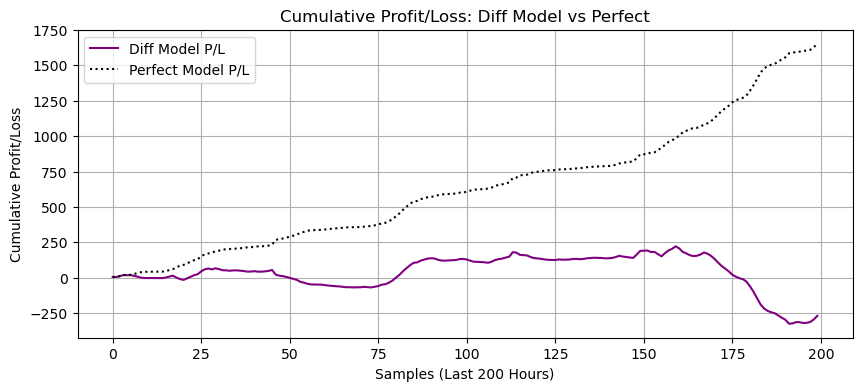

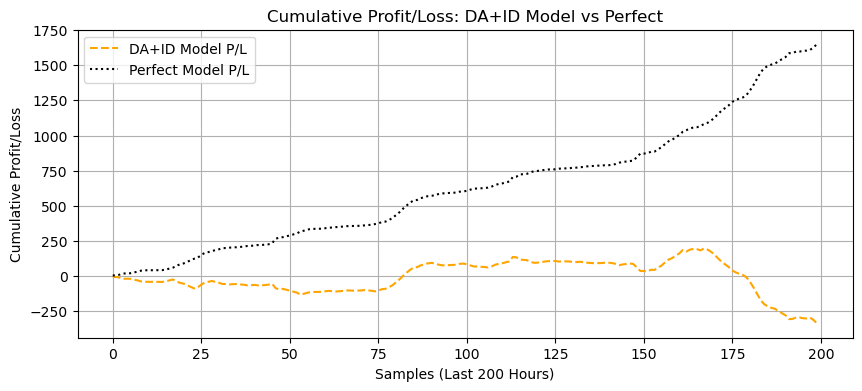

In [122]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def to_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return x

# Convert tensors to numpy
forecasts_diff_np = to_numpy(forecasts_diff)
targets_diff_np = to_numpy(targets_diff)

forecasts_da_np = to_numpy(forecasts_da)
targets_da_np = to_numpy(targets_da)
forecasts_id_np = to_numpy(forecasts_id)
targets_id_np = to_numpy(targets_id)

# Compute DA+ID difference
predicted_diff_separate_np = forecasts_da_np - forecasts_id_np
diff_targets_np = targets_da_np - targets_id_np

plot_length = 200

forecasts_diff_np_plt = forecasts_diff_np[:plot_length]
targets_diff_np_plt = targets_diff_np[:plot_length]

predicted_diff_separate_np_plt = predicted_diff_separate_np[:plot_length]
diff_targets_np_plt = diff_targets_np[:plot_length]

def profit_loss_series(pred_diff, actual_diff):
    sign_correct = (pred_diff * actual_diff) > 0
    profit_loss_values = (2 * sign_correct - 1) * np.abs(actual_diff)
    return np.cumsum(profit_loss_values)

# Compute cumulative profits for Diff model
cumulative_profit_loss_diff = profit_loss_series(forecasts_diff_np, targets_diff_np)
cumulative_profit_loss_diff_plt = cumulative_profit_loss_diff[:plot_length]

# Compute cumulative profits for DA+ID model
cumulative_profit_loss_sep = profit_loss_series(predicted_diff_separate_np, diff_targets_np)
cumulative_profit_loss_sep_plt = cumulative_profit_loss_sep[:plot_length]

# Perfect model profits
cumulative_profit_loss_perfect_diff = np.cumsum(np.abs(targets_diff_np))[:plot_length]
cumulative_profit_loss_perfect_sep = np.cumsum(np.abs(diff_targets_np))[:plot_length]

### Plot 1: Diff Model vs Perfect ###
fig1, ax1 = plt.subplots(figsize=(10,4))
ax1.plot(cumulative_profit_loss_diff_plt, label='Diff Model P/L', color='purple')
ax1.plot(cumulative_profit_loss_perfect_diff, label='Perfect Model P/L', color='black', linestyle=':')
ax1.set_title("Cumulative Profit/Loss: Diff Model vs Perfect")
ax1.set_xlabel("Samples (Last 200 Hours)")
ax1.set_ylabel("Cumulative Profit/Loss")
ax1.legend()
ax1.grid(True)
plt.show()

### Plot 2: DA+ID Model vs Perfect ###
fig2, ax2 = plt.subplots(figsize=(10,4))
ax2.plot(cumulative_profit_loss_sep_plt, label='DA+ID Model P/L', color='orange', linestyle='--')
ax2.plot(cumulative_profit_loss_perfect_sep, label='Perfect Model P/L', color='black', linestyle=':')
ax2.set_title("Cumulative Profit/Loss: DA+ID Model vs Perfect")
ax2.set_xlabel("Samples (Last 200 Hours)")
ax2.set_ylabel("Cumulative Profit/Loss")
ax2.legend()
ax2.grid(True)
plt.show()


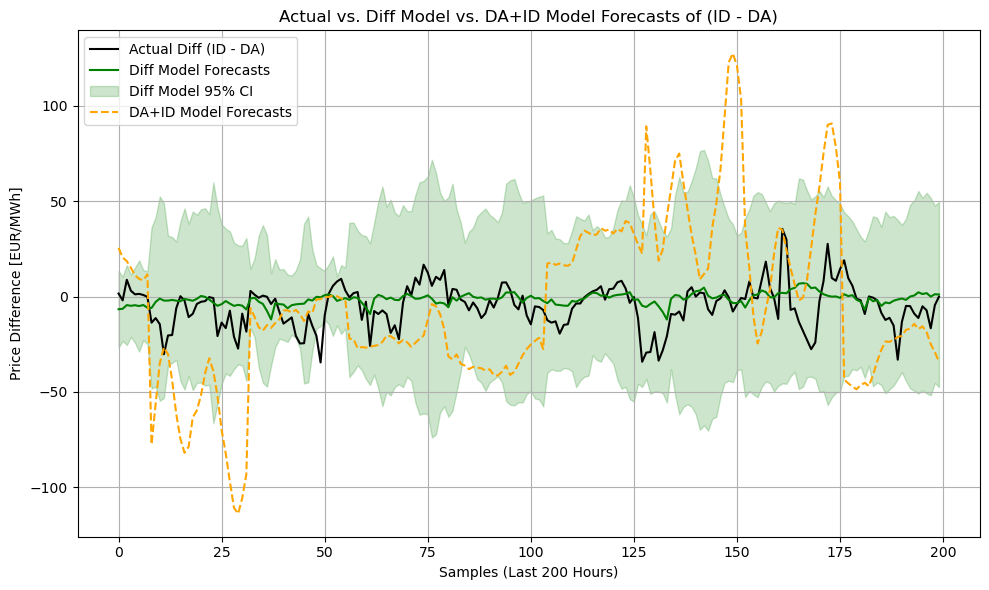

In [89]:
import matplotlib.pyplot as plt
import numpy as np

# Convert tensors to numpy arrays for plotting
def to_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return x

# Prepare data for plotting
plot_length = 200  # Only the last 200 hours
forecasts_diff_np = to_numpy(forecasts_diff)[-plot_length:]
targets_diff_np = to_numpy(targets_diff)[-plot_length:]
scales_diff_np = to_numpy(scales_diff)[-plot_length:]

forecasts_da_np = to_numpy(forecasts_da)[-plot_length:]
forecasts_id_np = to_numpy(forecasts_id)[-plot_length:]

# Compute predicted difference (DA+ID Model)
predicted_diff_separate_np = forecasts_id_np - forecasts_da_np

# Plot Actual vs Diff Model vs DA+ID Model (Last 200 Hours)
plt.figure(figsize=(10, 6))

# Plot the actual difference
plt.plot(targets_diff_np, label='Actual Diff (ID - DA)', color='black', linewidth=1.5)

# Plot the Diff model predictions with confidence intervals
plt.plot(forecasts_diff_np, label='Diff Model Forecasts', color='blue', linewidth=1.5)
plt.fill_between(np.arange(len(forecasts_diff_np)),
                 forecasts_diff_np - 1.96 * scales_diff_np,
                 forecasts_diff_np + 1.96 * scales_diff_np,
                 color='blue', alpha=0.2, label='Diff Model 95% CI')

# Plot the Separate DA+ID model predictions (ID_forecast - DA_forecast)
plt.plot(predicted_diff_separate_np, label='DA+ID Model Forecasts', color='purple', linestyle='--', linewidth=1.5)

# Add labels and title
plt.xlabel('Samples (Last 200 Hours)')
plt.ylabel('Price Difference [EUR/MWh]')
plt.title('Actual vs. Diff Model vs. DA+ID Model Forecasts of (ID - DA)')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


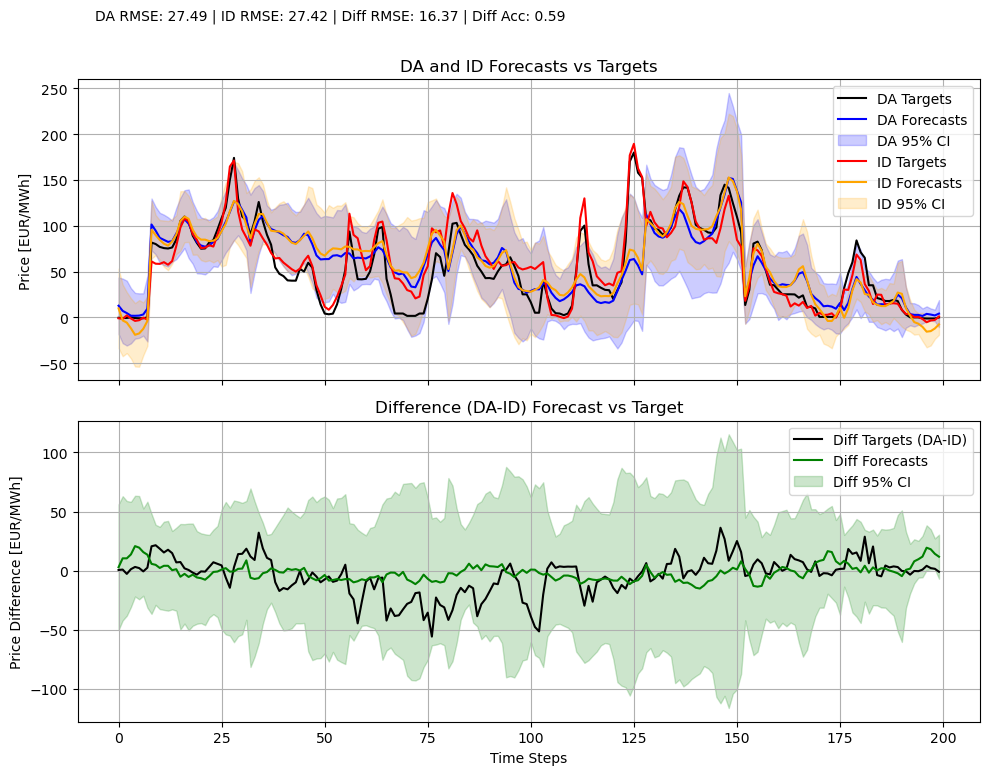

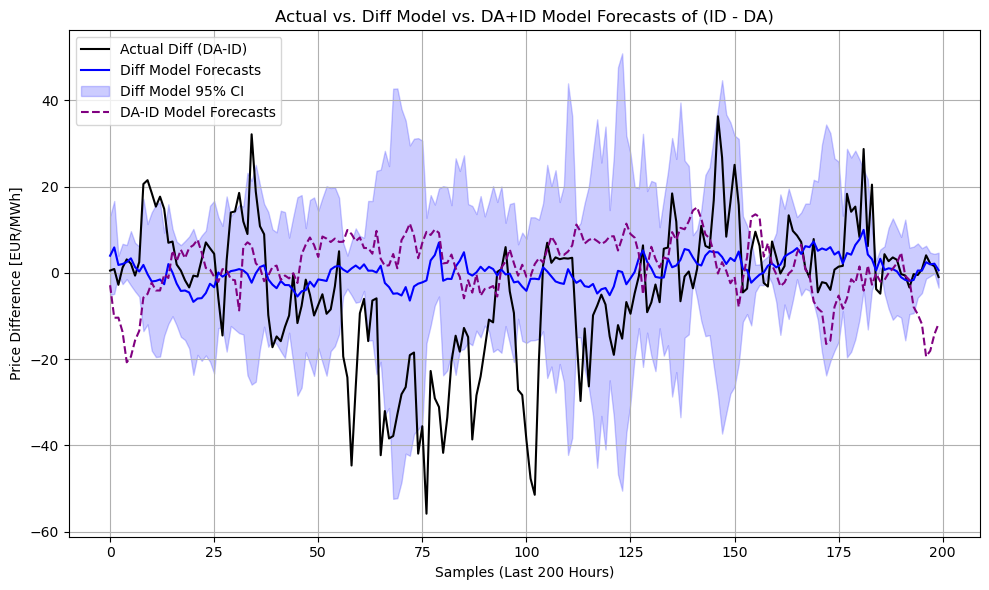

In [125]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Convert tensors to numpy arrays for plotting
def to_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return x

plot_length = 200  # Only the last 200 hours

# Convert forecasts and targets to numpy
forecasts_da_np = to_numpy(forecasts_da)[-plot_length:]
targets_da_np = to_numpy(targets_da)[-plot_length:]
scales_da_np = to_numpy(scales_da)[-plot_length:]

forecasts_id_np = to_numpy(forecasts_id)[-plot_length:]
targets_id_np = to_numpy(targets_id)[-plot_length:]
scales_id_np = to_numpy(scales_id)[-plot_length:]

# Compute the difference predictions and targets
diff_forecasts_np = forecasts_da_np-forecasts_id_np 
diff_targets_np = targets_da_np-targets_id_np

# Compute the standard deviation for the difference distribution
# Variances add, so we sum the squares and then take the square root.
diff_scales_np = np.sqrt(scales_da_np**2 + scales_id_np**2)

# Compute RMSE
mse_da = np.mean((forecasts_da_np - targets_da_np)**2)
rmse_da = np.sqrt(mse_da)

mse_id = np.mean((forecasts_id_np - targets_id_np)**2)
rmse_id = np.sqrt(mse_id)

mse_diff = np.mean((diff_forecasts_np - diff_targets_np)**2)
rmse_diff = np.sqrt(mse_diff)

def sign_accuracy(pred, actual):
    sign_correct = (pred * actual) > 0
    if len(sign_correct) > 0:
        return np.sum(sign_correct) / len(sign_correct)
    return np.nan

acc_diff_plot = sign_accuracy(diff_forecasts_np, diff_targets_np)

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot DA and ID forecasts with their CIs
axes[0].plot(targets_da_np, label='DA Targets', color='black')
axes[0].plot(forecasts_da_np, label='DA Forecasts', color='blue')
axes[0].fill_between(np.arange(plot_length),
                     forecasts_da_np - 1.96 * scales_da_np,
                     forecasts_da_np + 1.96 * scales_da_np,
                     color='blue', alpha=0.2, label='DA 95% CI')

axes[0].plot(targets_id_np, label='ID Targets', color='red')
axes[0].plot(forecasts_id_np, label='ID Forecasts', color='orange')
axes[0].fill_between(np.arange(plot_length),
                     forecasts_id_np - 1.96 * scales_id_np,
                     forecasts_id_np + 1.96 * scales_id_np,
                     color='orange', alpha=0.2, label='ID 95% CI')

axes[0].set_title("DA and ID Forecasts vs Targets")
axes[0].set_ylabel("Price [EUR/MWh]")
axes[0].legend()
axes[0].grid(True)

# Plot the difference (ID - DA) forecasts with their CIs
axes[1].plot(diff_targets_np, label='Diff Targets (DA-ID)', color='black')
axes[1].plot(diff_forecasts_np, label='Diff Forecasts', color='green')
axes[1].fill_between(np.arange(plot_length),
                     diff_forecasts_np - 1.96 * diff_scales_np,
                     diff_forecasts_np + 1.96 * diff_scales_np,
                     color='green', alpha=0.2, label='Diff 95% CI')

axes[1].set_title("Difference (DA-ID) Forecast vs Target")
axes[1].set_xlabel("Time Steps")
axes[1].set_ylabel("Price Difference [EUR/MWh]")
axes[1].legend()
axes[1].grid(True)

fig.text(0.1, 0.95,
         f"DA RMSE: {rmse_da:.2f} | ID RMSE: {rmse_id:.2f} | Diff RMSE: {rmse_diff:.2f} | Diff Acc: {acc_diff_plot:.2f}",
         fontsize=10, transform=fig.transFigure)

plt.tight_layout(rect=[0,0,1,0.92])
plt.show()
fig.savefig("combined_plot.png", dpi=300)


# Now plotting the separate figure comparing Actual, Diff Model, and DA+ID Model

# Extract the last 200 of forecasts_diff, targets_diff, scales_diff
forecasts_diff_np = to_numpy(forecasts_diff)[-plot_length:]
targets_diff_np = to_numpy(targets_diff)[-plot_length:]
scales_diff_np = to_numpy(scales_diff)[-plot_length:]  # Ensure scales_diff is defined as per your code

forecasts_da_np = to_numpy(forecasts_da)[-plot_length:]
forecasts_id_np = to_numpy(forecasts_id)[-plot_length:]

# Compute predicted difference from separate DA and ID forecasts
predicted_diff_separate_np = forecasts_id_np - forecasts_da_np

# Plot Actual vs Diff Model vs DA+ID Model (Last 200 Hours)
plt.figure(figsize=(10, 6))

# Plot the actual difference
plt.plot(targets_diff_np, label='Actual Diff (DA-ID)', color='black', linewidth=1.5)

# Plot the Diff model predictions with confidence intervals
plt.plot(forecasts_diff_np, label='Diff Model Forecasts', color='blue', linewidth=1.5)
plt.fill_between(np.arange(len(forecasts_diff_np)),
                 forecasts_diff_np - 1.96 * scales_diff_np,
                 forecasts_diff_np + 1.96 * scales_diff_np,
                 color='blue', alpha=0.2, label='Diff Model 95% CI')

# Plot the Separate DA+ID model predictions (ID_forecast - DA_forecast)
plt.plot(predicted_diff_separate_np, label='DA-ID Model Forecasts', color='purple', linestyle='--', linewidth=1.5)

# Add labels and title
plt.xlabel('Samples (Last 200 Hours)')
plt.ylabel('Price Difference [EUR/MWh]')
plt.title('Actual vs. Diff Model vs. DA+ID Model Forecasts of (ID - DA)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [154]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import torch.optim as optim

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

def to_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return x

def accuracy(forecasts,targets):
    if isinstance(forecasts, torch.Tensor):
        forecasts = forecasts.cpu().numpy()
    if isinstance(targets, torch.Tensor):
        targets = targets.cpu().numpy()

    # Avoid division by zero issues: We assume no zero differences
    # If zero differences can occur, we need a different approach.
    mask = (np.abs(forecasts*targets) > 0)
    temp = np.zeros_like(forecasts)
    temp[mask] = (forecasts[mask]*targets[mask]/np.abs(forecasts[mask]*targets[mask]))
    temp[temp==-1]=0
    accuracy_of_sign  = np.sum(temp)/len(forecasts)

    matches = temp==1
    mismatches = temp==0
    diff_values_matches = np.abs(targets[matches] - forecasts[matches]) if np.any(matches) else np.array([np.nan])
    diff_values_mismatches = np.abs(targets[mismatches] - forecasts[mismatches]) if np.any(mismatches) else np.array([np.nan])
    avg_price_paid_mismatches = np.mean(np.abs(targets[mismatches])) if np.any(mismatches) else np.nan
    avg_price_recieved_matches = np.mean(np.abs(targets[matches])) if np.any(matches) else np.nan
    std_price_paid_mismatches = np.std(np.abs(targets[mismatches])) if np.any(mismatches) else np.nan
    std_price_recieved_matches = np.std(np.abs(targets[matches])) if np.any(matches) else np.nan

    return accuracy_of_sign, np.nanmean(diff_values_matches), np.nanmean(diff_values_mismatches), avg_price_paid_mismatches, avg_price_recieved_matches, std_price_paid_mismatches, std_price_recieved_matches

def revenues(forecasts,targets):
    if isinstance(forecasts, torch.Tensor):
        forecasts = forecasts.cpu().numpy()
    if isinstance(targets, torch.Tensor):
        targets = targets.cpu().numpy()

    mask = (np.abs(forecasts*targets) > 0)
    temp = np.zeros_like(forecasts)
    temp[mask] = (forecasts[mask]*targets[mask]/np.abs(forecasts[mask]*targets[mask]))
    revenues  = np.sum(temp*targets)
    return revenues

class PricePredictionDataset(Dataset):
    def __init__(self, data, target_column='DA'):
        self.data = data
        self.target_column = target_column
        self.X, self.Y = self.prepare_data()

    def prepare_data(self):
        df = self.data
        # Assuming 690 days as per original code
        num_days = 690  
        assert len(df) >= num_days * 24, "Data does not have enough rows for 690 days."

        # Prepare Y (Targets)
        Y = np.zeros((num_days, 24))
        for d in range(num_days):
            Y[d, :] = df.loc[df.index[d * 24:(d + 1) * 24], self.target_column].to_numpy()
        Y = Y[7:-1, :]  # skip first 7 days and last day as per original logic

        # Prepare X (Features)
        X = np.zeros((700 + 1, 726))
        for d in range(7, 690 + 1):
            # The indexing code must match your original logic
            # For brevity, omitted detailed comments. Replicate original indexing carefully.

            # DA (just as example)
            X[d, :24] = df.loc[df.index[(d - 1) * 24:d * 24], 'DA'].to_numpy()
            X[d, 24:48] = df.loc[df.index[(d - 2) * 24:(d - 1) * 24], 'DA'].to_numpy()
            X[d, 48:72] = df.loc[df.index[(d - 3) * 24:(d - 2) * 24], 'DA'].to_numpy()

            # ID
            X[d, 72:96] = df.loc[df.index[(d - 7) * 24:(d - 6) * 24], 'ID'].to_numpy()
            X[d, 96:120] = df.loc[df.index[(d - 1) * 24:d * 24], 'ID'].to_numpy()
            X[d, 120:144] = df.loc[df.index[(d - 2) * 24:(d - 1) * 24], 'ID'].to_numpy()
            X[d, 144:168] = df.loc[df.index[(d - 3) * 24:(d - 2) * 24], 'ID'].to_numpy()
            X[d, 168:192] = df.loc[df.index[(d - 7) * 24:(d - 6) * 24], 'ID'].to_numpy()

            # Demand
            X[d, 192:216] = df.loc[df.index[d * 24:(d + 1) * 24], 'Demand'].to_numpy()
            X[d, 216:240] = df.loc[df.index[(d - 1) * 24:d * 24], 'Demand'].to_numpy()
            X[d, 240:264] = df.loc[df.index[(d - 7) * 24:(d - 6) * 24], 'Demand'].to_numpy()

            # Hour_Cos and Hour_Sin (Indices as in original code)
            X[d, 288:312] = df.loc[df.index[d * 24:(d + 1) * 24], 'Hour_Cos'].to_numpy()
            X[d, 336:360] = df.loc[df.index[d * 24:(d + 1) * 24], 'Hour_Sin'].to_numpy()

            # Day_Cos, Day_Sin, Month_Cos, Month_Sin (just one value per day)
            X[d, 360] = df.loc[df.index[(d - 2) * 24:(d - 1) * 24:24], 'Day_Cos'].to_numpy()
            X[d, 361] = df.loc[df.index[(d - 2) * 24:(d - 1) * 24:24], 'Day_Sin'].to_numpy()
            X[d, 362] = df.loc[df.index[(d - 2) * 24:(d - 1) * 24:24], 'Month_Cos'].to_numpy()
            X[d, 363] = df.loc[df.index[(d - 2) * 24:(d - 1) * 24:24], 'Month_Sin'].to_numpy()

            # Weekday
            X[d, 364] = df.loc[df.index[d * 24:(d + 1) * 24:24], 'Weekday'].to_numpy()

            # Predicted wind/solar and other features (indices as per original code)
            X[d, 365:389] = df.loc[df.index[d * 24:(d + 1) * 24], 'Madrid_wind_v_component_Predicted'].to_numpy()
            X[d, 389:413] = df.loc[df.index[d * 24:(d + 1) * 24], 'Madrid_wind_u_component_Predicted'].to_numpy()
            X[d, 413:437] = df.loc[df.index[d * 24:(d + 1) * 24], 'Barcelona_wind_v_component_Predicted'].to_numpy()
            X[d, 437:461] = df.loc[df.index[d * 24:(d + 1) * 24], 'Barcelona_wind_u_component_Predicted'].to_numpy()

            X[d, 461:485] = df.loc[df.index[d * 24:(d + 1) * 24], 'Madrid_solar_radiation'].to_numpy()
            X[d, 485:509] = df.loc[df.index[d * 24:(d + 1) * 24], 'Seville_solar_radiation'].to_numpy()

            X[d, 509:533] = df.loc[df.index[(d - 1) * 24:d * 24], 'Madrid_solar_radiation'].to_numpy()
            X[d, 533:557] = df.loc[df.index[(d - 1) * 24:d * 24], 'Seville_solar_radiation'].to_numpy()

            X[d, 557:581] = df.loc[df.index[(d - 1) * 24:d * 24], 'Castile-La Mancha (Wind)_wind_v_component'].to_numpy()
            X[d, 581:605] = df.loc[df.index[(d - 1) * 24:d * 24], 'Castile-La Mancha (Wind)_wind_u_component'].to_numpy()

            X[d, 629:653] = df.loc[df.index[(d - 1) * 24:d * 24], 'Wind_Generation'].to_numpy()
            X[d, 653:677] = df.loc[df.index[(d - 1) * 24:d * 24], 'PV_Generation'].to_numpy()
            X[d, 677:701] = df.loc[df.index[(d - 2) * 24:(d - 1) * 24], 'Wind_Generation'].to_numpy()
            X[d, 701:725] = df.loc[df.index[(d - 2) * 24:(d - 1) * 24], 'PV_Generation'].to_numpy()

        X = X[7:-1, :]  # matches Y indexing
        return torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32)

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

class ProbNNModel(nn.Module):
    def __init__(self, input_size, output_size, distribution):
        super(ProbNNModel, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.distribution = distribution

        # Define layers
        self.batch_norm = nn.BatchNorm1d(input_size)
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)

        if distribution == 'Normal':
            self.fc4 = nn.Linear(128, output_size * 2)  # loc and scale
        else:
            raise NotImplementedError(f"Distribution {distribution} not implemented.")

    def forward(self, x):
        x = self.batch_norm(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)

        loc = x[:, :self.output_size]
        scale = 3e-3 + 3 * F.softplus(x[:, self.output_size:])
        return loc, scale

class NegativeLogLikelihood(nn.Module):
    def __init__(self):
        super(NegativeLogLikelihood, self).__init__()

    def forward(self, loc, scale, target):
        two_pi = torch.tensor(2.0 * np.pi, device=loc.device, dtype=loc.dtype)
        log_prob = -0.5 * (torch.log(two_pi) + torch.log(scale**2) + ((target - loc)**2) / (scale**2))
        return -torch.mean(log_prob)

def train_model(model, train_loader, val_loader, params):
    criterion = NegativeLogLikelihood()
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])

    epochs = params.get('epochs', 500)
    best_val_loss = float('inf')
    best_model_weights = None

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            loc, scale = model(inputs)
            loss = criterion(loc, scale, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                loc, scale = model(inputs)
                loss = criterion(loc, scale, targets)
                val_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_weights = model.state_dict()

    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)

    return model

def evaluate_model(model, loader):
    model.eval()
    forecasts, targets, scales = [], [], []
    with torch.no_grad():
        for inputs, target in loader:
            loc, scale = model(inputs)
            forecasts.append(loc)
            targets.append(target)
            scales.append(scale)

    forecasts_flat = torch.cat(forecasts, axis=0).flatten()
    targets_flat = torch.cat(targets, axis=0).flatten()
    scales_flat = torch.cat(scales, axis=0).flatten()

    return forecasts_flat, targets_flat, scales_flat

### Load data
my_old_columns = [
    'Year', 'Month', 'Day', 'Hour', 'DA', 'ID', 'Demand', 'Wind_Generation',
    'PV_Generation', 'Predicted_Demand', 'Price_EUR_MWh', 'Volume_MWh',
    'Weekday', 'Castile-La Mancha (Wind)_wind_u_component',
    'Castile-La Mancha (Wind)_wind_v_component',
    'Escatrón-Chiprana-Samper (Solar)_solar_radiation',
    'Madrid_solar_radiation', 'Madrid_wind_u_component',
    'Madrid_wind_v_component', 'Seville_solar_radiation',
    'Seville_wind_u_component', 'Seville_wind_v_component',
    'Madrid_wind_v_component_Predicted', 'Madrid_wind_u_component_Predicted',
    'Valencia_temperature', 'Barcelona_wind_u_component_Predicted',
    'Barcelona_wind_v_component_Predicted', 'Hour_Sin', 'Hour_Cos',
    'Day_Sin', 'Day_Cos', 'Month_Sin', 'Month_Cos', 'Diff'
]

data_spain = pd.read_csv(r'../formatted_data/formatted_data_withWeatherPrediction.csv')
data_spain['Weekday'] = pd.to_datetime(data_spain[['Year', 'Month', 'Day']]).dt.weekday
data_spain['Diff'] = data_spain['DA'] - data_spain['ID']
if 'valid_time' in data_spain.columns:
    data_spain = data_spain.drop(columns=['valid_time'])
data_spain = data_spain[my_old_columns]

### Create a dataset for DA (for indexing)
full_da_dataset = PricePredictionDataset(data_spain, target_column='DA')
data_split = 0.8
train_size = int(data_split * len(full_da_dataset))
val_size = len(full_da_dataset) - train_size
train_dataset_da, val_dataset_da = random_split(full_da_dataset, [train_size, val_size])

# Extract the indices used for train/val
train_indices = train_dataset_da.indices
val_indices = val_dataset_da.indices

# Create datasets for ID and Diff with the same indexing
full_id_dataset = PricePredictionDataset(data_spain, target_column='ID')
full_diff_dataset = PricePredictionDataset(data_spain, target_column='Diff')

# Create subsets for ID
train_dataset_id = torch.utils.data.Subset(full_id_dataset, train_indices)
val_dataset_id = torch.utils.data.Subset(full_id_dataset, val_indices)

# Create subsets for Diff
train_dataset_diff = torch.utils.data.Subset(full_diff_dataset, train_indices)
val_dataset_diff = torch.utils.data.Subset(full_diff_dataset, val_indices)

# DataLoaders
batch_size = 32
train_loader_da = DataLoader(train_dataset_da, batch_size=batch_size, shuffle=True)
val_loader_da = DataLoader(val_dataset_da, batch_size=batch_size, shuffle=False)

train_loader_id = DataLoader(train_dataset_id, batch_size=batch_size, shuffle=True)
val_loader_id = DataLoader(val_dataset_id, batch_size=batch_size, shuffle=False)

train_loader_diff = DataLoader(train_dataset_diff, batch_size=batch_size, shuffle=True)
val_loader_diff = DataLoader(val_dataset_diff, batch_size=batch_size, shuffle=False)

# Train models for DA, ID, and Diff
input_size = full_da_dataset.X.shape[1]
output_size = 24

def run_training_and_evaluation(train_loader, val_loader, target_name):
    model = ProbNNModel(input_size=input_size, output_size=output_size, distribution='Normal')
    params = {'learning_rate': 0.0001, 'epochs': 500}
    model = train_model(model, train_loader, val_loader, params)
    forecasts_flat, targets_flat, scales_flat = evaluate_model(model, val_loader)

    mse_loss = nn.MSELoss()
    mse = mse_loss(forecasts_flat, targets_flat)
    rmse = torch.sqrt(mse)
    print(f"{target_name} RMSE: {rmse.item():.4f}")

    return forecasts_flat, targets_flat, scales_flat

# DA
forecasts_da, targets_da, scales_da = run_training_and_evaluation(train_loader_da, val_loader_da, 'DA')

# ID
forecasts_id, targets_id, scales_id = run_training_and_evaluation(train_loader_id, val_loader_id, 'ID')

# Diff
forecasts_diff, targets_diff, scales_diff = run_training_and_evaluation(train_loader_diff, val_loader_diff, 'Diff')



/tmp/ipykernel_420322/2457287213.py:102: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X[d, 360] = df.loc[df.index[(d - 2) * 24:(d - 1) * 24:24], 'Day_Cos'].to_numpy()
/tmp/ipykernel_420322/2457287213.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X[d, 361] = df.loc[df.index[(d - 2) * 24:(d - 1) * 24:24], 'Day_Sin'].to_numpy()
/tmp/ipykernel_420322/2457287213.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X[d, 362] = df.loc[df.index[(d - 2) * 24:(d - 

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 726])

DA Model:
Sign Accuracy: 0.9426328502415459
Revenues: 121863.3

ID Model:
Sign Accuracy: 0.9456521739130435
Revenues: 121259.65

Diff Model:
Sign Accuracy: 0.5561594202898551
Revenues: 3222.8

DA+ID Model:
Sign Accuracy: 0.4746376811594203
Revenues: 2996.3203



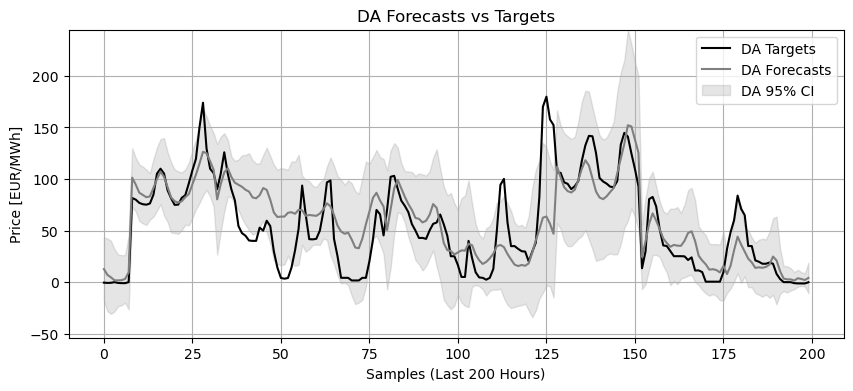

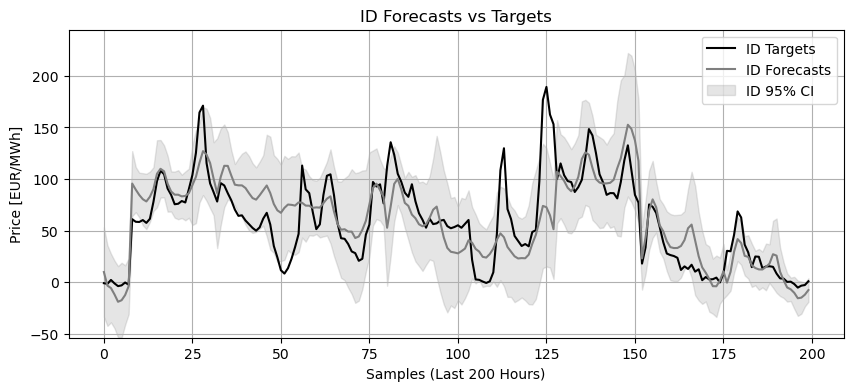

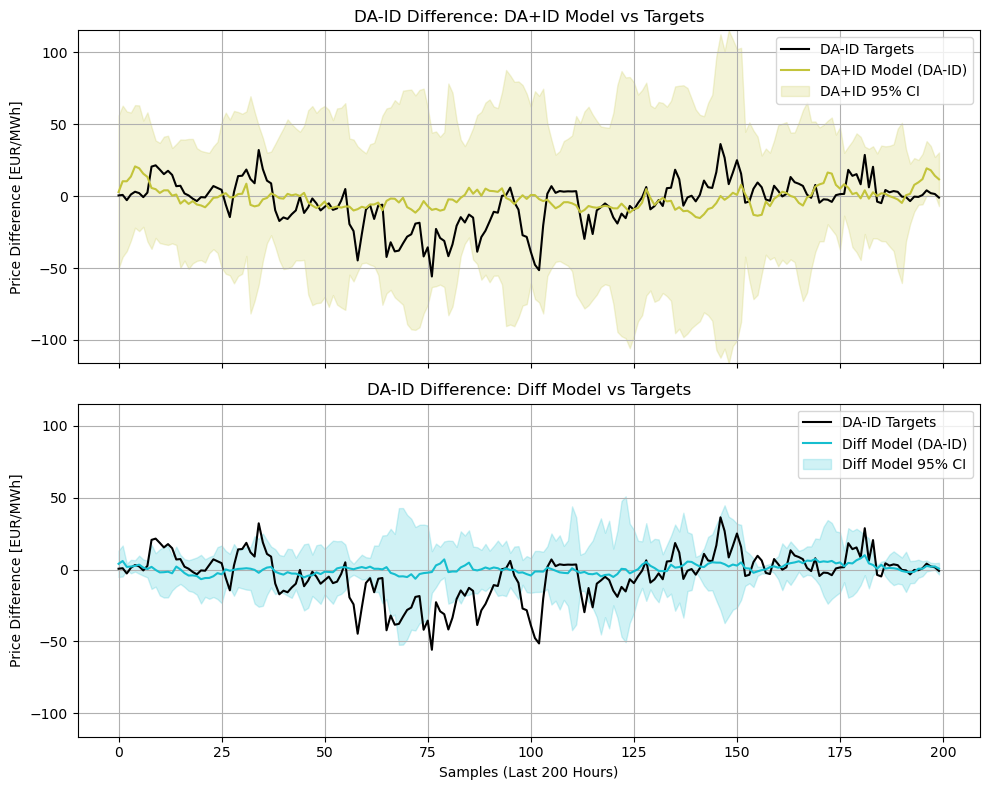

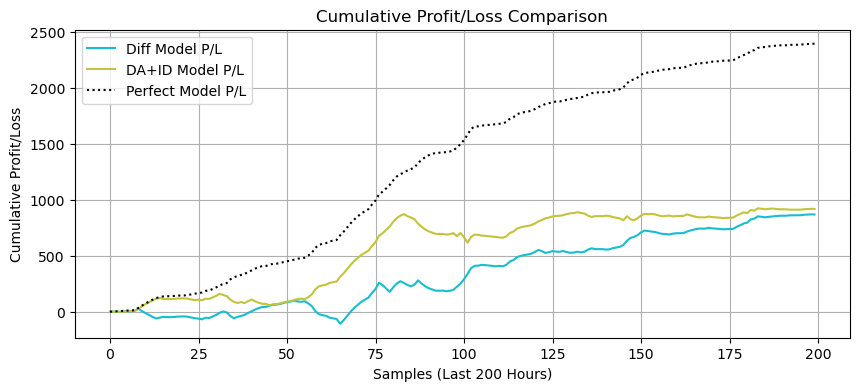

In [152]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Desired color scheme
colors = {
    'forecasts': '#7F7F7F',  # grey
    'diff_model': '#16BECF', # blue
    'da_id_model': '#C3C43B',# yellow
    'targets': 'black'
}

def to_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return x

# Assuming accuracy and revenues functions are defined and
# forecasts_da, targets_da, scales_da,
# forecasts_id, targets_id, scales_id,
# forecasts_diff, targets_diff, scales_diff,
# predicted_diff_separate, diff_targets are all defined.

acc_da, mean_match_da, mean_mismatch_da, avg_paid_mismatch_da, avg_rec_match_da, std_paid_mismatch_da, std_rec_match_da = accuracy(forecasts_da, targets_da)
rev_da = revenues(forecasts_da, targets_da)

print("DA Model:")
print("Sign Accuracy:", acc_da)
print("Revenues:", rev_da)
print()

acc_id, mean_match_id, mean_mismatch_id, avg_paid_mismatch_id, avg_rec_match_id, std_paid_mismatch_id, std_rec_match_id = accuracy(forecasts_id, targets_id)
rev_id = revenues(forecasts_id, targets_id)

print("ID Model:")
print("Sign Accuracy:", acc_id)
print("Revenues:", rev_id)
print()

acc_diff, mean_match_diff, mean_mismatch_diff, avg_paid_mismatch_diff, avg_rec_match_diff, std_paid_mismatch_diff, std_rec_match_diff = accuracy(forecasts_diff, targets_diff)
rev_diff = revenues(forecasts_diff, targets_diff)

print("Diff Model:")
print("Sign Accuracy:", acc_diff)
print("Revenues:", rev_diff)
print()

acc_diff_sep, mean_match_diff_sep, mean_mismatch_diff_sep, avg_paid_mismatch_diff_sep, avg_rec_match_diff_sep, std_paid_mismatch_diff_sep, std_rec_match_sep = accuracy(forecasts_id - forecasts_da, targets_da - targets_id)
rev_diff_sep = revenues(forecasts_id - forecasts_da, targets_da - targets_id)

print("DA+ID Model:")
print("Sign Accuracy:", acc_diff_sep)
print("Revenues:", rev_diff_sep)
print()

predicted_diff_separate = forecasts_da - forecasts_id
diff_targets = targets_da - targets_id

plot_length = 200
forecasts_da_np = to_numpy(forecasts_da)[-plot_length:]
targets_da_np = to_numpy(targets_da)[-plot_length:]
scales_da_np = to_numpy(scales_da)[-plot_length:]

forecasts_id_np = to_numpy(forecasts_id)[-plot_length:]
targets_id_np = to_numpy(targets_id)[-plot_length:]
scales_id_np = to_numpy(scales_id)[-plot_length:]

forecasts_diff_np = to_numpy(forecasts_diff)[-plot_length:]
targets_diff_np = to_numpy(targets_diff)[-plot_length:]
scales_diff_np = to_numpy(scales_diff)[-plot_length:]

predicted_diff_separate_np = to_numpy(predicted_diff_separate)[-plot_length:]
diff_targets_np = to_numpy(diff_targets)[-plot_length:]

def profit_loss_series(pred_diff, actual_diff):
    sign_correct = (pred_diff * actual_diff) > 0
    profit_loss_values = (2 * sign_correct - 1) * np.abs(actual_diff)
    return np.cumsum(profit_loss_values)

cumulative_profit_loss_diff = profit_loss_series(forecasts_diff_np, diff_targets_np)
cumulative_profit_loss_sep = profit_loss_series(predicted_diff_separate_np, diff_targets_np)
cumulative_profit_loss_perfect = np.cumsum(np.abs(diff_targets_np))

###########################################
# Determine common y-limits for DA and ID forecasts
###########################################
da_min = np.min([targets_da_np, 
                 forecasts_da_np - 1.96*scales_da_np, 
                 forecasts_da_np + 1.96*scales_da_np])
da_max = np.max([targets_da_np, 
                 forecasts_da_np - 1.96*scales_da_np, 
                 forecasts_da_np + 1.96*scales_da_np])

id_min = np.min([targets_id_np, 
                 forecasts_id_np - 1.96*scales_id_np, 
                 forecasts_id_np + 1.96*scales_id_np])
id_max = np.max([targets_id_np, 
                 forecasts_id_np - 1.96*scales_id_np, 
                 forecasts_id_np + 1.96*scales_id_np])

common_min_da_id = min(da_min, id_min)
common_max_da_id = max(da_max, id_max)

###########################################
# 1. DA Forecast vs Targets with CI
###########################################
fig1, ax1 = plt.subplots(figsize=(10,4))
ax1.plot(targets_da_np, label='DA Targets', color=colors['targets'])
ax1.plot(forecasts_da_np, label='DA Forecasts', color=colors['forecasts'])
ax1.fill_between(np.arange(plot_length),
                 forecasts_da_np - 1.96 * scales_da_np,
                 forecasts_da_np + 1.96 * scales_da_np,
                 color=colors['forecasts'], alpha=0.2, label='DA 95% CI')
ax1.set_title("DA Forecasts vs Targets")
ax1.set_xlabel("Samples (Last 200 Hours)")
ax1.set_ylabel("Price [EUR/MWh]")
ax1.legend()
ax1.grid(True)
ax1.set_ylim(common_min_da_id, common_max_da_id)  # Apply common y-limits
plt.show()

###########################################
# 2. ID Forecast vs Targets with CI
###########################################
fig2, ax2 = plt.subplots(figsize=(10,4))
ax2.plot(targets_id_np, label='ID Targets', color=colors['targets'])
ax2.plot(forecasts_id_np, label='ID Forecasts', color=colors['forecasts'])
ax2.fill_between(np.arange(plot_length),
                 forecasts_id_np - 1.96 * scales_id_np,
                 forecasts_id_np + 1.96 * scales_id_np,
                 color=colors['forecasts'], alpha=0.2, label='ID 95% CI')
ax2.set_title("ID Forecasts vs Targets")
ax2.set_xlabel("Samples (Last 200 Hours)")
ax2.set_ylabel("Price [EUR/MWh]")
ax2.legend()
ax2.grid(True)
ax2.set_ylim(common_min_da_id, common_max_da_id)  # Apply common y-limits
plt.show()

###########################################
# Compute combined scales for DA+ID difference model
###########################################
diff_scales_separate_np = np.sqrt(scales_da_np**2 + scales_id_np**2)

# Determine common y-limits for the difference subplots
sep_min = np.min([diff_targets_np, 
                  predicted_diff_separate_np - 1.96 * diff_scales_separate_np,
                  predicted_diff_separate_np + 1.96 * diff_scales_separate_np])
sep_max = np.max([diff_targets_np, 
                  predicted_diff_separate_np - 1.96 * diff_scales_separate_np,
                  predicted_diff_separate_np + 1.96 * diff_scales_separate_np])

diff_min_val = np.min([diff_targets_np, 
                       forecasts_diff_np - 1.96 * scales_diff_np,
                       forecasts_diff_np + 1.96 * scales_diff_np])
diff_max_val = np.max([diff_targets_np, 
                       forecasts_diff_np - 1.96 * scales_diff_np,
                       forecasts_diff_np + 1.96 * scales_diff_np])

common_min_diff = min(sep_min, diff_min_val)
common_max_diff = max(sep_max, diff_max_val)

###########################################
# 3. One figure with two subplots:
#    Top: DA-ID (separate) model vs DA-ID targets with CI
#    Bottom: Diff model vs DA-ID targets with CI
###########################################
fig, axes = plt.subplots(2, 1, figsize=(10,8), sharex=True)

# Top subplot: DA+ID model (DA-ID)
axes[0].plot(diff_targets_np, label='DA-ID Targets', color=colors['targets'])
axes[0].plot(predicted_diff_separate_np, label='DA+ID Model (DA-ID)', color=colors['da_id_model'])
axes[0].fill_between(np.arange(plot_length),
                     predicted_diff_separate_np - 1.96 * diff_scales_separate_np,
                     predicted_diff_separate_np + 1.96 * diff_scales_separate_np,
                     color=colors['da_id_model'], alpha=0.2, label='DA+ID 95% CI')
axes[0].set_title("DA-ID Difference: DA+ID Model vs Targets")
axes[0].set_ylabel("Price Difference [EUR/MWh]")
axes[0].legend()
axes[0].grid(True)
axes[0].set_ylim(common_min_diff, common_max_diff)  # Apply common y-limits

# Bottom subplot: Diff model
axes[1].plot(diff_targets_np, label='DA-ID Targets', color=colors['targets'])
axes[1].plot(forecasts_diff_np, label='Diff Model (DA-ID)', color=colors['diff_model'])
axes[1].fill_between(np.arange(plot_length),
                     forecasts_diff_np - 1.96 * scales_diff_np,
                     forecasts_diff_np + 1.96 * scales_diff_np,
                     color=colors['diff_model'], alpha=0.2, label='Diff Model 95% CI')
axes[1].set_title("DA-ID Difference: Diff Model vs Targets")
axes[1].set_xlabel("Samples (Last 200 Hours)")
axes[1].set_ylabel("Price Difference [EUR/MWh]")
axes[1].legend()
axes[1].grid(True)
axes[1].set_ylim(common_min_diff, common_max_diff)  # Apply common y-limits

plt.tight_layout()
plt.show()

###########################################
# 4. Cumulative Revenues
###########################################
plt.figure(figsize=(10,4))
# For the P/L lines, we can use the diff_model and da_id_model colors
plt.plot(cumulative_profit_loss_diff, label='Diff Model P/L', color=colors['diff_model'])
plt.plot(cumulative_profit_loss_sep, label='DA+ID Model P/L', color=colors['da_id_model'])
plt.plot(cumulative_profit_loss_perfect, label='Perfect Model P/L', color=colors['targets'], linestyle=':')
plt.title("Cumulative Profit/Loss Comparison")
plt.xlabel("Samples (Last 200 Hours)")
plt.ylabel("Cumulative Profit/Loss")
plt.legend()
plt.grid(True)
plt.show()


In [148]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def to_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return x

# Example color scheme (adjust as desired)
colors = {
    'targets': 'black',
    'da_forecasts': '#c3c43b',   # yellow
    'id_forecasts': '#7F7F7F',   # grey (same as DA, change if you want different)
    'da_id_forecasts': '#C3C43B',# yellow
    'diff_forecasts': '#16BECF', # blue
    'perfect': 'black'
}

def profit_loss_series(pred_diff, actual_diff):
    sign_correct = (pred_diff * actual_diff) > 0
    profit_loss_values = (2 * sign_correct - 1) * np.abs(actual_diff)
    return np.cumsum(profit_loss_values)


def slice_arrays(arrays, start, length):
    """Slice each array in arrays to [start:start+length]."""
    return [arr[start:start+length] for arr in arrays]

def plot_forecasts_with_ci(targets, forecasts, scales, title, forecast_label, ci_label, target_label='Targets',
                           start=0, length=200, forecast_color='#7F7F7F', target_color='black'):
    """
    Plot forecasts vs targets with confidence intervals.
    - targets, forecasts, scales are numpy arrays.
    - start, length define the segment of data to plot.
    - forecast_color and target_color define the line colors.
    """
    t, f, s = slice_arrays([targets, forecasts, scales], start, length)
    x = np.arange(len(t))

    plt.figure(figsize=(10,4))
    plt.plot(t, label=target_label, color=target_color)
    plt.plot(f, label=forecast_label, color=forecast_color)
    plt.fill_between(x, f - 1.96*s, f + 1.96*s, color=forecast_color, alpha=0.2, label=ci_label)
    plt.title(title)
    plt.xlabel("Samples")
    plt.ylabel("Price [EUR/MWh]")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_two_subplots_with_ci(top_targets, top_forecasts, top_scales, top_title, top_label,
                              bottom_targets, bottom_forecasts, bottom_scales, bottom_title, bottom_label,
                              start=0, length=200,
                              top_color='#C3C43B', bottom_color='#16BECF', target_color='black'):
    """
    Plot two subplots (top and bottom) each with targets, forecasts, and CI.
    Allows specifying start and length independently for both (assuming they align).
    """
    # Slice arrays
    tt, tf, ts = slice_arrays([top_targets, top_forecasts, top_scales], start, length)
    bt, bf, bs = slice_arrays([bottom_targets, bottom_forecasts, bottom_scales], start, length)

    x = np.arange(len(tt))

    # Determine common y-limits
    top_min = np.min([tt, tf - 1.96*ts, tf + 1.96*ts])
    top_max = np.max([tt, tf - 1.96*ts, tf + 1.96*ts])

    bot_min = np.min([bt, bf - 1.96*bs, bf + 1.96*bs])
    bot_max = np.max([bt, bf - 1.96*bs, bf + 1.96*bs])

    common_min = min(top_min, bot_min)
    common_max = max(top_max, bot_max)

    fig, axes = plt.subplots(2, 1, figsize=(10,8), sharex=True)

    # Top subplot
    axes[0].plot(tt, label='Targets', color=target_color)
    axes[0].plot(tf, label=top_label, color=top_color)
    axes[0].fill_between(x, tf - 1.96*ts, tf + 1.96*ts, color=top_color, alpha=0.2, label='95% CI')
    axes[0].set_title(top_title)
    axes[0].set_ylabel("Price Difference [EUR/MWh]")
    axes[0].legend()
    axes[0].grid(True)
    axes[0].set_ylim(common_min, common_max)

    # Bottom subplot
    axes[1].plot(bt, label='Targets', color=target_color)
    axes[1].plot(bf, label=bottom_label, color=bottom_color)
    axes[1].fill_between(x, bf - 1.96*bs, bf + 1.96*bs, color=bottom_color, alpha=0.2, label='95% CI')
    axes[1].set_title(bottom_title)
    axes[1].set_xlabel("Samples")
    axes[1].set_ylabel("Price Difference [EUR/MWh]")
    axes[1].legend()
    axes[1].grid(True)
    axes[1].set_ylim(common_min, common_max)

    plt.tight_layout()
    plt.show()

def plot_cumulative_profit_loss(diff_cum, sep_cum, perfect_cum, start=0, length=200,
                                diff_color='#16BECF', sep_color='#C3C43B', perfect_color='black'):
    """
    Plot cumulative profit/loss comparison.
    Allows specifying start and length.
    """
    dc, sc, pc = slice_arrays([diff_cum, sep_cum, perfect_cum], start, length)
    plt.figure(figsize=(10,4))
    plt.plot(dc, label='Diff Model P/L', color=diff_color)
    plt.plot(sc, label='DA+ID Model P/L', color=sep_color)
    plt.plot(pc, label='Perfect Model P/L', color=perfect_color, linestyle=':')
    plt.title("Cumulative Profit/Loss Comparison")
    plt.xlabel("Samples")
    plt.ylabel("Cumulative Profit/Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage (assuming you have forecasts and targets defined):
# forecasts_da, targets_da, scales_da, ...
# Just replace the arrays and colors as desired.




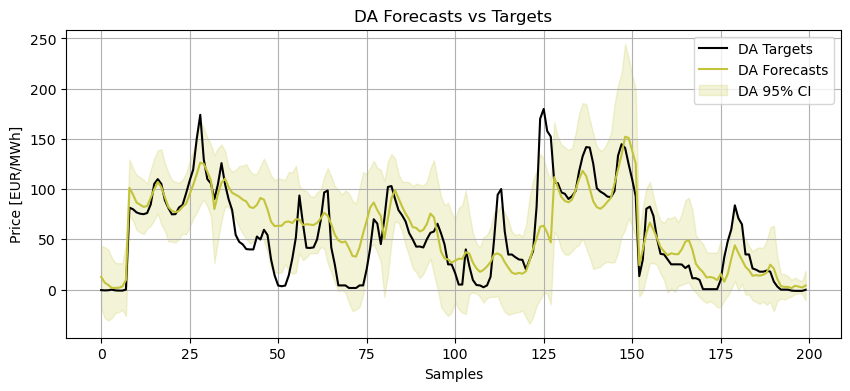

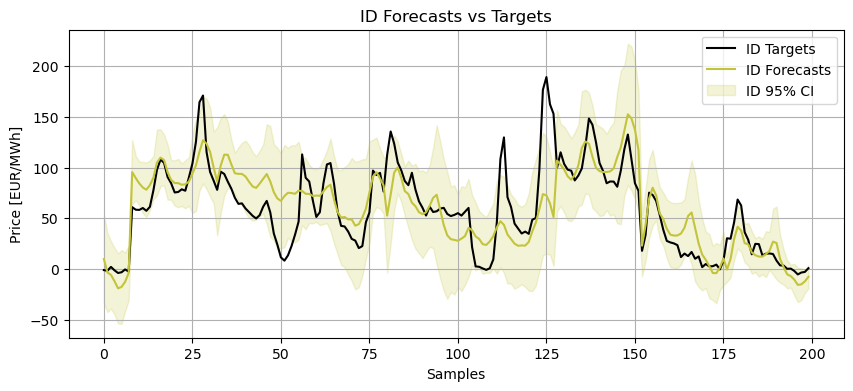

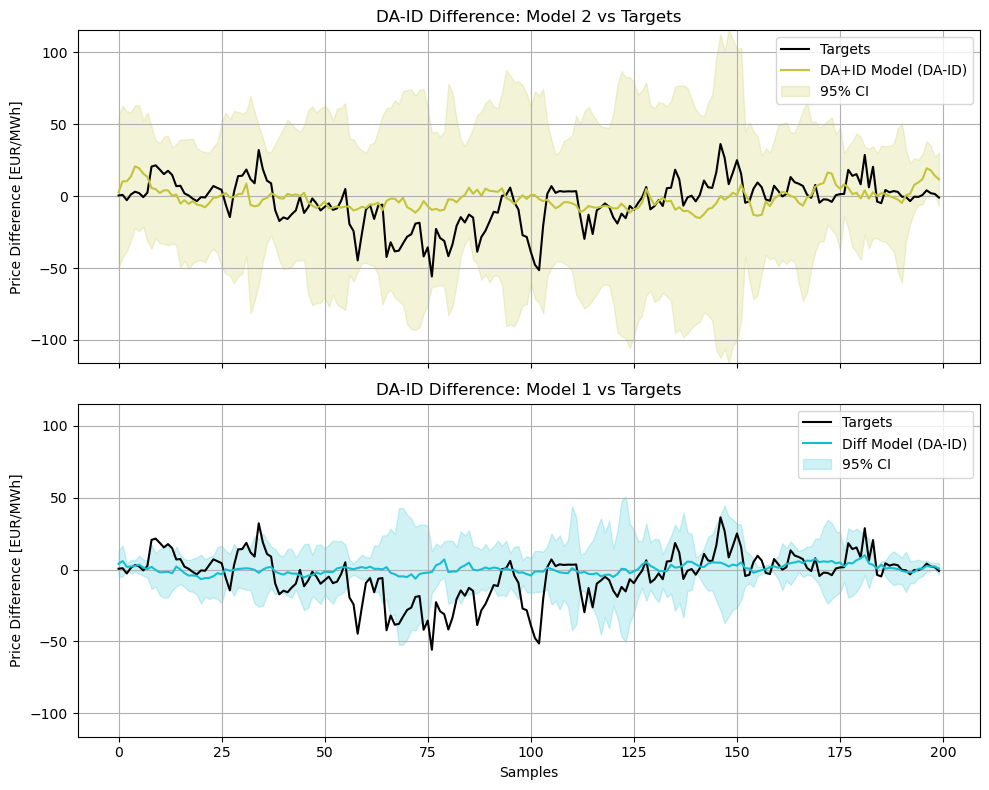

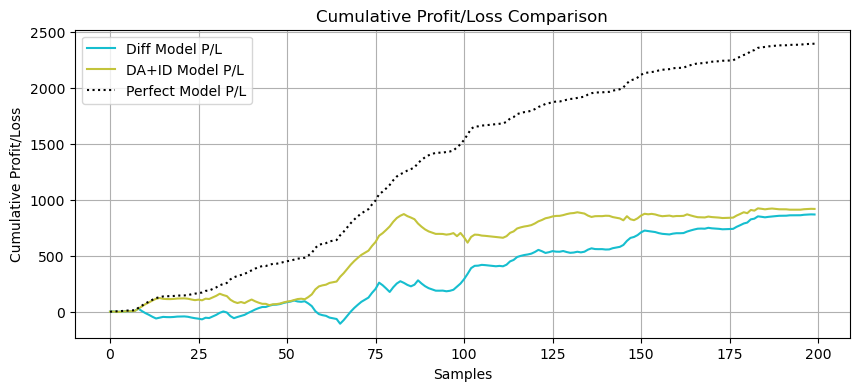

In [161]:
# Example start and length values
# Adjust these as needed to select different periods
start_da = 0
length_da = 200

start_id = 0
length_id = 200

start_diff = 0
length_diff = 200

start_revenue = 0
length_revenue = 1500

# Compute diff_scales_separate_np if not already done
diff_scales_separate_np = np.sqrt(scales_da_np**2 + scales_id_np**2)

###########################################
# 1. DA Forecast vs Targets with CI
###########################################
plot_forecasts_with_ci(
    targets=targets_da_np,
    forecasts=forecasts_da_np,
    scales=scales_da_np,
    title="DA Forecasts vs Targets",
    forecast_label='DA Forecasts',
    ci_label='DA 95% CI',
    target_label='DA Targets',
    start=start_da, length=length_da,
    forecast_color='#c3c43b', 
    target_color=colors['targets']
)

###########################################
# 2. ID Forecast vs Targets with CI
###########################################
plot_forecasts_with_ci(
    targets=targets_id_np,
    forecasts=forecasts_id_np,
    scales=scales_id_np,
    title="ID Forecasts vs Targets",
    forecast_label='ID Forecasts',
    ci_label='ID 95% CI',
    target_label='ID Targets',
    start=start_id, length=length_id,
    forecast_color='#c3c43b', 
    target_color=colors['targets']
)

###########################################
# 3. One figure with two subplots:
#    Top: DA-ID (separate) model vs DA-ID targets with CI
#    Bottom: Diff model vs DA-ID targets with CI
###########################################
plot_two_subplots_with_ci(
    top_targets=diff_targets_np, 
    top_forecasts=predicted_diff_separate_np, 
    top_scales=diff_scales_separate_np, 
    top_title="DA-ID Difference: Model 2 vs Targets", 
    top_label='DA+ID Model (DA-ID)',

    bottom_targets=diff_targets_np, 
    bottom_forecasts=forecasts_diff_np, 
    bottom_scales=scales_diff_np, 
    bottom_title="DA-ID Difference: Model 1 vs Targets", 
    bottom_label='Diff Model (DA-ID)',

    start=start_diff, length=length_diff,
    top_color='#c3c43b', 
    bottom_color='#16BECF', 
    target_color=colors['targets']
)

###########################################
# 4. Cumulative Revenues
###########################################
plot_cumulative_profit_loss(
    diff_cum=cumulative_profit_loss_diff,
    sep_cum=cumulative_profit_loss_sep,
    perfect_cum=cumulative_profit_loss_perfect,
    start=start_revenue, length=length_revenue,
    diff_color='#16BECF',
    sep_color='#c3c43b',
    perfect_color=colors['targets']
)
